In [1]:
import sys
import matplotlib
if 'matplotlib.pyplot' not in sys.modules.keys():
    matplotlib.use("Agg")
import matplotlib.pyplot as plt
import json
import numpy as np
import pickle 

%matplotlib notebook

DeltInx=[100, 300, 200]

path = "./wallops_intDel/LaunchDay7_20210516-Dallas/"
# file_name = "PreLaunchAndFlight-data_file_230k_1-05_16_21.txt"
# file_name = "PreLaunchAndFlight-data_file_230k_2-05_16_21.txt"
file_name = "Dallas1_FlightData_5-16-2021.txt"
# file_name = "Dallas4_FlightData_5-16-2021.txt"

# path = "./wallops_intDel/LaunchDay7_20210516-Main/" 
# file_name = "HorizCheck-data_file_230k_1-05_16_21.txt"
# file_name = "HorizCheck-data_file_230k_2-05_16_21.txt"
# file_name = "HorizCheck-data_file_230k_3-05_16_21.txt"
# file_name = "HorizCheck-data_file_230k_4-05_16_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_1-05_16_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_2-05_16_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_3-05_16_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_4-05_16_21.txt"
# file_name = "PreLaunch-data_file_230k_1-05_16_21.txt"
# file_name = "PreLaunch-data_file_230k_2-05_16_21.txt"
# file_name = "PreLaunch-data_file_230k_3-05_16_21.txt"
# file_name = "PreLaunch-data_file_230k_4-05_16_21.txt"
# file_name = "Flight-data_file_230k_1-05_16_21.txt"
# file_name = "Flight-data_file_230k_2-05_16_21.txt"
# file_name = "Flight-data_file_230k_3-05_16_21.txt"
# file_name = "Flight-data_file_230k_4-05_16_21.txt"

# path = "./wallops_intDel/LaunchDay6_20210515-Main/"
# file_name = "HorizCheck-data_file_230k_1-05_15_21.txt"
# file_name = "HorizCheck-data_file_230k_2-05_15_21.txt"
# file_name = "HorizCheck-data_file_230k_3-05_15_21.txt"
# file_name = "HorizCheck-data_file_230k_4-05_15_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_1-05_15_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_2-05_15_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_3-05_15_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_4-05_15_21.txt"

# path = "./wallops_intDel/LaunchDay6_20210515-Dallas/"
# file_name = "HorizCheck-data_file_230k_1-05_15_21.txt"
# file_name = "HorizCheck-data_file_230k_2-05_15_21.txt"
# file_name = "LaunchPrep1-data_file_230k_1-05_15_21.txt"
# file_name = "LaunchPrep1-data_file_230k_2-05_15_21.txt"
# file_name = "PreLaunch-data_file_230k_1-05_15_21.txt"
# file_name = "PreLaunch-data_file_230k_2-05_15_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_1-05_15_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_2-05_15_21.txt"

# path = "./wallops_intDel/RailCheck2_20210514-Main/"
# file_name = "Check1-data_file_230k_1-05_14_21.txt"
# file_name = "Check1-data_file_230k_2-05_14_21.txt"
# file_name = "Check1-data_file_230k_3-05_14_21.txt"
# file_name = "Check1-data_file_230k_4-05_14_21.txt"

# path = "./wallops_intDel/RailCheck2_20210514-Dallas/"
# file_name = "Check1-data_file_230k_1-05_14_21.txt"
# file_name = "Check1-data_file_230k_2-05_14_21.txt"

# path = "./wallops_intDel/LaunchDay4_20210511-Main/"
# file_name = "HorizCheck-data_file_230k_1-05_11_21.txt"
# file_name = "HorizCheck-data_file_230k_2-05_11_21.txt"
# file_name = "HorizCheck-data_file_230k_3-05_11_21.txt"
# file_name = "HorizCheck-data_file_230k_4-05_11_21.txt"
# file_name = "PreLaunchToT-3_Rec1-data_file_230k_1-05_11_21.txt"
# file_name = "PreLaunchToT-3_Rec1-data_file_230k_2-05_11_21.txt"
# file_name = "PreLaunchToT-3_Rec1-data_file_230k_3-05_11_21.txt"
# file_name = "PreLaunchToT-3_Rec1-data_file_230k_4-05_11_21.txt"
# file_name = "PreLaunchToT-3_Rec2-data_file_230k_1-05_11_21.txt"
# file_name = "PreLaunchToT-3_Rec2-data_file_230k_3-05_11_21.txt"
# file_name = "PreLaunchToT-3_Rec2-data_file_230k_4-05_11_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_1-05_11_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_2-05_11_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_3-05_11_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_4-05_11_21.txt"

# path = "./wallops_intDel/LaunchDay4_20210511-Dallas/"
# file_name = "HorizCheck-data_file_230k_1-05_11_21.txt"
# file_name = "HorizCheck-data_file_230k_2-05_11_21.txt"
# file_name = "PreLaunchToT-3_Rec1-data_file_230k_1-05_11_21.txt"
# file_name = "PreLaunchToT-3_Rec1-data_file_230k_2-05_11_21.txt"
# file_name = "PreLaunchToT-3_Rec2-data_file_230k_1-05_11_21.txt"
# file_name = "PreLaunchToT-3_Rec2-data_file_230k_2-05_11_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_1-05_11_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_2-05_11_21.txt"

# path = "./wallops_intDel/LaunchDay3_20210510-Main/"
# file_name = "HorizCheck-data_file_230k_1-05_10_21.txt"
# file_name = "HorizCheck-data_file_230k_2-05_10_21.txt"
# file_name = "HorizCheck-data_file_230k_3-05_10_21.txt"
# file_name = "HorizCheck-data_file_230k_4-05_10_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_1-05_10_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_2-05_10_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_3-05_10_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_4-05_10_21.txt"

# path = "./wallops_intDel/LaunchDay3_20210510-Dallas/"
# file_name = "HorizCheck-data_file_230k_1-05_10_21.txt"
# file_name = "HorizCheck-data_file_230k_2-05_10_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_1-05_10_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_2-05_10_21.txt"

# path = "./wallops_intDel/LaunchDay2_20210509-Main/"
# file_name = "HorizCheck-data_file_230k_1-05_09_21.txt"
# file_name = "HorizCheck-data_file_230k_2-05_09_21.txt"
# file_name = "HorizCheck-data_file_230k_3-05_09_21.txt"
# file_name = "HorizCheck-data_file_230k_4-05_09_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_1-05_09_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_2-05_09_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_3-05_09_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_4-05_09_21.txt"

# path = "./wallops_intDel/LaunchDay2_20210509-Dallas/"
# file_name = "HorizCheck-data_file_230k_1-05_09_21.txt"
# file_name = "HorizCheck-data_file_230k_2-05_09_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_1-05_09_21.txt"
# file_name = "VertAndBoxCheck-data_file_230k_2-05_09_21.txt"

# path = "./wallops_intDel/LaunchDay1_20210508-Main/"
# file_name = "HorizCheck-data_file_230k_1-05_08_21.txt"
# file_name = "HorizCheck-data_file_230k_2-05_08_21.txt"
# file_name = "HorizCheck-data_file_230k_3-05_08_21.txt"Il 
# file_name = "HorizCheck-data_file_230k_4-05_08_21.txt"
# file_name = "VertCheck-data_file_230k_1-05_08_21.txt"
# file_name = "VertCheck-data_file_230k_2-05_08_21.txt"
# file_name = "VertCheck-data_file_230k_3-05_08_21.txt"
# file_name = "VertCheck-data_file_230k_4-05_08_21.txt"
# file_name = "BoxCheck-data_file_230k_1-05_08_21.txt"
# file_name = "BoxCheck-data_file_230k_2-05_08_21.txt"
# file_name = "BoxCheck-data_file_230k_3-05_08_21.txt"
# file_name = "BoxCheck-data_file_230k_4-05_08_21.txt"

# path = "./wallops_intDel/LaunchDay1_20210508-Dallas/"
# file_name = "HorizCheck-data_file_230k_1-05_08_21.txt"
# file_name = "HorizCheck-data_file_230k_2-05_08_21.txt"
# file_name = "VertCheck-data_file_230k_1-05_08_21.txt"
# file_name = "VertCheck-data_file_230k_2-05_08_21.txt"

# path = "./wallops_intDel/DryRun_20210507-Dallas/"
# file_name = "NoLadder_Check-data_file_230k_1-05_07_21.txt"
# file_name = "NoLadder_Check-data_file_230k_2-05_07_21.txt"
# file_name = "HorizCheck-data_file_230k_1-05_07_21.txt"
# file_name = "HorizCheck-data_file_230k_2-05_07_21.txt"
# file_name = "VertCheckA-data_file_230k_1-05_07_21.txt"
# file_name = "VertCheckA-data_file_230k_2-05_07_21.txt"
# file_name = "VertCheckB-data_file_230k_1-05_07_21.txt"
# file_name = "VertCheckB-data_file_230k_2-05_07_21.txt"
# file_name = "Launch-data_file_230k_1-05_07_21.txt"; #{'pip1': [0.9975, 1.005], 'pip0': [1.0025, 1.0125], 'gyro': [-0.05, 0.015], 'accel': [1.75, 7.75], 'mag': [-0.3, 0.1], 'cad': [15, 55]}
# file_name = "Launch-data_file_230k_2-05_07_21.txt"
# file_name = "VertTestB_Aborted-data_file_230k_1-05_07_21.txt"
# file_name = "VertTestB_Aborted-data_file_230k_2-05_07_21.txt"


# path = "./wallops_intDel/DryRun_20210507-Main/"
# file_name = "HorizCheck-data_file_230k_1-05_07_21.txt, HorizCheck-data_file_230k_2-05_07_21.txt, HorizCheck-data_file_230k_3-05_07_21.txt, HorizCheck-data_file_230k_4-05_07_21.txt, 
# Launch-data_file_230k_1-05_07_21.txt, Launch-data_file_230k_2-05_07_21.txt, Launch-data_file_230k_3-05_07_21.txt, Launch-data_file_230k_4-05_07_21.txt, 
# TurnOn1-data_file_230k_1-05_07_21.txt, TurnOn1-data_file_230k_2-05_07_21.txt, TurnOn1-data_file_230k_3-05_07_21.txt, TurnOn1-data_file_230k_4-05_07_21.txt, 
# VertCheckA-data_file_230k_1-05_07_21.txt, VertCheckA-data_file_230k_2-05_07_21.txt, VertCheckA-data_file_230k_3-05_07_21.txt, VertCheckA-data_file_230k_4-05_07_21.txt, 
# VertCheckB-data_file_230k_1-05_07_21.txt, VertCheckB-data_file_230k_2-05_07_21.txt, VertCheckB-data_file_230k_3-05_07_21.txt, VertCheckB-data_file_230k_4-05_07_21.txt, 
# VertCheckB_Aborted-data_file_230k_1-05_07_21.txt, VertCheckB_Aborted-data_file_230k_2-05_07_21.txt, VertCheckB_Aborted-data_file_230k_3-05_07_21.txt, 
# VertCheckB_Aborted-data_file_230k_4-05_07_21.txt"

# path ="./wallops_intDel/20210506_TurnOn-Main/"
# file_name = "data_file_230k_1-FirstPart-05_06_21.txt"
# file_name = "data_file_230k_2-FirstPart-05_06_21.txt"
# file_name = "data_file_230k_3-FirstPart-05_06_21.txt"
# file_name = "data_file_230k_4-FirstPart-05_06_21.txt"
# file_name = "data_file_230k_1-SecondPart-05_06_21.txt"
# file_name = "data_file_230k_2-SecondPart-05_06_21.txt"
# file_name = "data_file_230k_3-SecondPart-05_06_21.txt"
# file_name = "data_file_230k_4-SecondPart-05_06_21.txt"

# path = "./wallops_intDel/20210506_TurnOn-Dallas/"
# file_name = "data_file_230k_1-FirstPart-05_06_21.txt"
# file_name = "data_file_230k_2-FirstPart-05_06_21.txt"
# file_name = "data_file_230k_1-SecondPart-05_06_21.txt"
# file_name = "data_file_230k_2-SecondPart-05_06_21.txt"

# path = "./wallops_intDel/PreFlight_TurnON_20210505-Dallas/"
# file_name = "Dallas1_Pre-FLight_TurnON_5-5-2021.txt"
# file_name = "Dallas4_Pre-Flight_TurnON_5-5-2021.txt"

# path = "./wallops_intDel/RailOn_Playback-Main/"
# file_name = "data_file_230k_1-RailOn_Playback-05_05_21.txt"
# file_name = "data_file_230k_2-RailOn_Playback-05_05_21.txt"
# file_name = "data_file_230k_3-RailOn_Playback-05_05_21.txt"
# file_name = "data_file_230k_4-RailOn_Playback-05_05_21.txt"

# path = "./wallops_intDel/RailOn_Playback-Dallas/"
# file_name = "data_file_230k_1-RailOn_Playback-05_06_21.txt"
# file_name = "data_file_230k_2-RailOn_Playback-05_06_21.txt"

# path = "./wallops_intDel/RailOn-Main/"
# file_name = "data_file_230k_1-RailOn-05_05_21.txt"
# file_name = "data_file_230k_2-RailOn-05_05_21.txt"
# file_name = "data_file_230k_3-RailOn-05_05_21.txt"
# file_name = "data_file_230k_4-RailOn-05_05_21.txt"

# path = "./wallops_intDel/RailOn-Dallas/"
# file_name = "data_file_230k_1-RailOn-05_05_21.txt"
# file_name = "data_file_230k_2-RailOn-05_05_21.txt"

# path = "./wallops_intDel/20210429_Tests-Dallas/"
# file_name = "data_file_230k_1-Test8-04_29_21.txt"
# file_name = "data_file_230k_2-Test8-04_29_21.txt"
# file_name = "data_file_230k_1-Test9-04_29_21.txt"
# file_name = "data_file_230k_2-Test9-04_29_21.txt"
# file_name = "Dallas1_Pre-FLight_ALLFire_4-29-2021.txt"
# file_name = "Dallas4_Pre-FLight_ALLFire_4-29-2021.txt"

# path = "./wallops_intDel/20210429_Tests-Main/"
# file_name = "data_file_230k_1-Test8-04_29_21.txt"
# file_name = "data_file_230k_2-Test8-04_29_21.txt"
# file_name = "data_file_230k_3-Test8-04_29_21.txt"
# file_name = "data_file_230k_4-Test8-04_29_21.txt"
# file_name = "data_file_230k_1-Test8B-04_29_21.txt"
# file_name = "data_file_230k_2-Test8B-04_29_21.txt"
# file_name = "data_file_230k_3-Test8B-04_29_21.txt"
# file_name = "data_file_230k_4-Test8B-04_29_21.txt"
# file_name = "data_file_230k_1-Test9-04_29_21.txt"
# file_name = "data_file_230k_2-Test9-04_29_21.txt"
# file_name = "data_file_230k_3-Test9-04_29_21.txt"
# file_name = "data_file_230k_4-Test9-04_29_21.txt"

# path = "./"
# file_name = "data_file_230k-Test_program2-042321.txt"
# path = "./wallops_intDel/20210419_playbacks-Main/"
# file_name = "data_file_230k_1_20210401_postvibeACMHighShort_PB20210419.txt"; # figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000}; yLnZooms={'gyro': [-0.05, 0.025], 'pip1': [1.0051624003087203, 1.0101624003087202], 'pip0': [1.0008795252057614, 1.0058795252057613], 'cad': [0, 50]}
#         # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [1296, 1346]}; yLnZooms={'pip1': [1.0051624003087203, 1.0101624003087202], 'pip0': [1.0008795252057614, 1.0058795252057613], 'gyro': [-0.04, 0.025], 'accel': [-11, 2], 'mag': [-0.2, 0.15], 'cad': [15, 55]}
# file_name = "data_file_230k_2_20210401_postvibeACMHighShort_PB20210419.txt"; # figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000}; yLnZooms={'gyro': [-0.05, 0.05], 'pip1': [1.0074981428741954, 1.0174981428741952], 'pip0': [1.0061597848505905, 1.0161597848505903], 'cad': [0, 50]}
#         # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [1296, 1346]}; yLnZooms={'gyro': [-0.05, 0.025], 'pip1': [1.0074981428741954, 1.0174981428741952], 'pip0': [1.0061597848505905, 1.0161597848505903], 'accel': [-0.5, 10.5], 'cad': [15, 55]}
# file_name = "data_file_230k_3_20210401_postvibeACMHighShort_PB20210419.txt"; # figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000}; yLnZooms={'gyro': [-0.02, 0.015], 'pip1': [1.0036186996092524, 1.0136186996092522], 'pip0': [0.9981573508295213, 1.0081573508295212], 'mag': [-0.045, 0.0324], 'cad': [0, 50]}
#         # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [1296, 1346]}; yLnZooms={'pip1': [1.0036186996092524, 1.0136186996092522], 'pip0': [0.9981573508295213, 1.0081573508295212], 'gyro': [-0.0156, 0.0091], 'accel': [-11.3, 1.84], 'mag': [-0.036, 0.005], 'cad': [15, 55]}
# file_name = "data_file_230k_4_20210401_postvibeACMHighShort_PB20210419.txt"; # figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000}; yLnZooms={'pip1': [1.0065919330633262, 1.016591933063326], 'pip0': [1.0111656256228438, 1.0211656256228436], 'gyro': [-0.035, 0.104], 'accel': [-8, 12], 'mag': [-0.25, 0.1875], 'cad': [0, 50]}
#         # figsuffix = 'ZoomB'; x`LnZooms={'xCzoom': 1000, 'axis1': [1296, 1346]}; yLnZooms={'pip1': [1.0090919330633261, 1.014091933063326], 'pip0': [1.0136656256228438, 1.0186656256228437], 'gyro': [-0.02, 0.0182], 'accel': [-0.675, 10.7], 'mag': [-0.2, 0.0925], 'cad': [15, 55]}

# path = "./wallops_intDel/20210412_playbacks-Main/"
# file_name = "data_file_230k_1_20210401_postvibeACMHighShort_PB20210412.txt";# figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000}; yLnZooms={'pip1': [1, 1.015], 'pip0': [1, 1.015], 'cad': [0, 50]}
        # figsuffix = 'ZoomB'; {'xCzoom': 1000, 'axis1': [1296, 1346]}; {'pip1': [1.002, 1.0085], 'pip0': [1.002, 1.0085], 'gyro': [-0.05, 0.025], 'accel': [-10.5, 2.5], 'mag': [-0.2, 0.15], 'cad': [15, 55]}
# file_name = "data_file_230k_2_20210401_postvibeACMHighShort_PB20210412.txt";# figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000}; yLnZooms={'pip1': [1.005, 1.015], 'pip0': [1.005, 1.015], 'gyro': [-1, 5], 'accel': [-1, 25], 'mag': [-0.25, 0.75], 'cad': [0, 50]}
        # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [1296, 1346]}; yLnZooms={'pip1': [1.0075, 1.015], 'pip0': [1.0075, 1.015], 'gyro': [-0.05, 0.025], 'accel': [-0.5, 10.5], 'mag': [-0.15, 0.075], 'cad': [15, 55]}
# file_name = "data_file_230k_3_20210401_postvibeACMHighShort_PB20210412.txt"; # figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000}; yLnZooms={'pip1': [1.0, 1.015], 'pip0': [1.0, 1.015], 'gyro': [-2.5, 5], 'accel': [-12, 5], 'mag': [-0.25, 0.75], 'cad': [0, 50]}
        # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [1296, 1346]}; yLnZooms={'pip1': [1.0, 1.0125], 'pip0': [1.0, 1.01], 'gyro': [-0.015, 0.008], 'accel': [-10.725, 1.4], 'mag': [-0.035, 0.00475], 'cad': [15, 55]}
# file_name = "data_file_230k_4_20210401_postvibeACMHighShort_PB20210412txt.txt"; # figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000}; yLnZooms={'pip1': [1.005, 1.02], 'pip0': [1.005, 1.02], 'gyro': [-2.5, 6.5], 'accel': [-2.2, 25.5], 'mag': [-0.25, 0.75], 'cad': [0, 50]}
        # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [1296, 1346]}; yLnZooms={'pip1': [1.011, 1.0125], 'pip0': [1.0145, 1.0175], 'gyro': [-0.0178, 0.017], 'accel': [-0.6175, 10.398], 'mag': [-0.19, 0.092], 'cad': [15, 55]}

# path = "./wallops_intDel/20210401_GPS_Rollout-Dallas/"
# file_name = "Dallas1_R4_GPSRollout_4-1-2021.txt"
# file_name = "Dallas4_R4_GPSRollout_4-1-2021.txt"

# path = "./wallops_intDel/Dallas_PostVibe_20210401/"
# file_name = "Dallas1_PostVibe_ALLFire_4-1-2021.txt"
# file_name = "Dallas4_PostVibe_ALLFire_4-1-2021.txt"

# path = "./wallops_intDel/20210408_playbacks-Main/"
# file_name = "data_file_230k_1_20210402_GPS_Rollout.txt"
# file_name = "data_file_230k_2_20210402_GPS_Rollout.txt"
# file_name = "data_file_230k_3_20210402_GPS_Rollout.txt"
# file_name = "data_file_230k_4_20210402_GPS_Rollout.txt"
# file_name = "data_file_230k_1_20210401_postvibeACMHighShort.txt"; # figsuffix="ZoomB"; xLnZooms={'xCzoom': 1000}; yLnZooms={'pip1': [1.004908870615653, 1.009908870615653], 'pip0': [1.0003972792886646, 1.0053972792886645], 'gyro': [-0.04, 0.025], 'accel': [-10.975, 1.9], 'mag': [-0.2, 0.15], 'cad': [15, 55]}
# file_name = "data_file_230k_2_20210401_postvibeACMHighShort.txt"; # figsuffix="ZoomB"; xLnZooms={'xCzoom': 1000}; yLnZooms={'pip1': [1.0072502640750847, 1.0172502640750845], 'pip0': [1.006172605447257, 1.0161726054472568], 'gyro': [-0.04, 0.02], 'accel': [-0.25, 10.975], 'mag': [-0.14, 0.1], 'cad': [15, 55]}
# file_name = "data_file_230k_3_20210401_postvibeACMHighShort.txt"; # figsuffix="ZoomB"; xLnZooms={'xCzoom': 1000}; yLnZooms={'pip1': [1.0032114551477687, 1.0132114551477684], 'pip0': [0.9981322869658552, 1.008132286965855], 'gyro': [-0.0175, 0.008], 'accel': [-10.975, 1.5], 'mag': [-0.04, 0.005], 'cad': [15, 55]}
# file_name = "data_file_230k_4_20210401_postvibeACMHighShort.txt"; # figsuffix="ZoomB"; xLnZooms={'xCzoom': 1000}; yLnZooms={'pip1': [1.0045172841294743, 1.014517284129474], 'pip0': [1.0104713185418832, 1.020471318541883], 'gyro': [-0.02, 0.02], 'accel': [-0.75, 11], 'mag': [-0.2, 0.1], 'cad': [15, 55]}

# path = "./calc_startTime/"
# file_name = "data_file_230k-Shield02_startTime_test1.txt"
# file_name = "data_file_230k-Shield02_startTime_test2.txt"

# path = "./"
# file_name = "data_file_230k-EVT_test3.txt"

# path = "./wallops_intDel/PostVibe_Test_20210401-Main/"
# # file_name = "data_file_230k_1_20210401_Aborted_postvibe.txt", data_file_230k_2_20210401_Aborted_postvibe.txt,
# #  data_file_230k_2_20210401_Aborted_postvibe.txt, data_file_230k_3_20210401_Aborted_postvibe.txt,data_file_230k_4_20210401_Aborted_postvibe.txt,

# file_name = "data_file_230k_1_20210401_turnOn_test1.txt"
# file_name = "data_file_230k_2_20210401_turnOn_test1.txt"
# file_name = "data_file_230k_3_20210401_turnOn_test1.txt"
# file_name = "data_file_230k_4_20210401_turnOn_test1.txt"

# file_name = "data_file_230k_1_20210401_postVibe.txt"
# file_name = "data_file_230k_2_20210401_postVibe.txt"
# file_name = "data_file_230k_3_20210401_postVibe.txt"
# file_name = "data_file_230k_4_20210401_postVibe.txt"

# file_name = "data_file_230k_1_20210401_postVibe_noFire.txt"
# file_name = "data_file_230k_2_20210401_postVibe_noFire.txt" 
# file_name = "data_file_230k_3_20210401_postVibe_noFire.txt" 
# file_name = "data_file_230k_4_20210401_postVibe_noFire.txt"

# path = "./wallops_intDel/PostVibe_Test_20210401-Dallas/"
# file_name = "data_file_230k_1_20210401_Aborted_postvibe.txt"
# file_name = "data_file_230k_1_20210401_postVibe.txt"
# file_name = "data_file_230k_1_20210401_postVibe_noFire.txt"
# file_name = "data_file_230k_1_20210401_turnOn_test1.txt"
# file_name = "data_file_230k_2_20210401_Aborted_postvibe.txt"
# file_name = "data_file_230k_2_20210401_postVibe.txt"
# file_name = "data_file_230k_2_20210401_postVibe_noFire.txt"
# file_name = "data_file_230k_2_20210401_turnOn_test1.txt"

# path = "./wallops_intDel/Dallas_Deployments_20210331/"
# file_name = "Dallas1_R4_Dallas1Deployment_3-31-2021.txt"; # EVT = 1485; figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000, 'axis1': [1480, 1495]}; yLnZooms={'pip1': [-10,7], 'pip0': [-5.5, 5.5], 'mag': [-0.5, 0.5], 'cad': [0, 50]}
#                                                   #  figsuffix = 'ZoomB'; xLnZooms = {'xCzoom': 1000, 'axis1': [1484, 1489]}; yLnZooms={'pip1': [0.99, 1.01], 'pip0': [0.975, 1.025], 'gyro': [-1.75, 1.5], 'accel': [-15, 15], 'mag': [-0.35, 0.35], 'cad': [15, 55]}
# file_name = "Dallas4_R4_Dallas1Deployment_3-31-2021.txt"; # figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000, 'axis1': [1480, 1495]}; yLnZooms={'pip1': [1.0282033421556434, 1.0382033421556431], 'pip0': [1.0186301321122682, 1.028630132112268], 'gyro': [-0.035, 0.02], 'accel': [-11, 5], 'mag': [-0.094, 0.25], 'cad': [0, 50]}
                                                    # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [1470, 1522]}; yLnZooms={}'pip1': [1.0282033421556434, 1.0382033421556431], 'pip0': [1.0186301321122682, 1.028630132112268], 'gyro': [-0.035, 0.02], 'accel': [-11, 5], 'mag': [-0.094, 0.25], 'cad': [15, 55]}
# file_name = "Dallas4_R4_Dallas4Deployment_3-31-2021.txt"; # EVT=2664; figsuffix='ZoomA';  xLnZooms={'xCzoom': 1000, 'axis1': [2659, 2674]}; yLnZooms={'gyro': [-3, 6], 'mag': [-0.5, 0.5], 'cad': [0, 50]}; 
                                                   # figsuffix='ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [2663, 2668]}; yLnZooms={'pip1': [1.0245, 1.0395], 'pip0': [1.0154999999999998, 1.0305], 'gyro': [-3, 6], 'accel': [-40, 25], 'mag': [-0.5, 0.5], 'cad': [15, 55]}

# path = "./wallops_intDel/Tests_20210330-Main/"
# file_name = "data_file_230k_1_20210330_SpinAndBoomDeploy.txt"
# file_name = "data_file_230k_2_20210330_SpinAndBoomDeploy.txt"
# file_name = "data_file_230k_3_20210330_SpinAndBoomDeploy.txt"
# file_name = "data_file_230k_4_20210330_SpinAndBoomDeploy.txt"
# file_name = "data_file_230k_1_20210330_FwdBaDeploy.txt"
# file_name = "data_file_230k_2_20210330_FwdBaDeploy.txt"
# file_name = "data_file_230k_3_20210330_FwdBaDeploy.txt"
# file_name = "data_file_230k_4_20210330_FwdBaDeploy.txt"

# # file_name = "data_file_230k_1_20210330_preFwdBaDeploy.txt"
# # file_name = "data_file_230k_1_20210330_preSpin.txt"
# # file_name = "data_file_230k_2_20210330_preFwdBaDeploy.txt"
# # file_name = "data_file_230k_2_20210330_preSpin.txt"
# # file_name = "data_file_230k_3_20210330_preFwdBaDeploy.txt"
# # file_name = "data_file_230k_3_20210330_preSpin.txt"
# # file_name = "data_file_230k_4_20210330_preFwdBaDeploy.txt"
# # file_name = "data_file_230k_4_20210330_preSpin.txt"

# path = "./wallops_intDel/Tests_20210330-Dallas/"
# file_name = "data_file_230k_1_20210330_preSpin.txt"
# file_name = "data_file_230k_2_20210330_preSpin.txt"
# file_name = "data_file_230k_1_20210330_SpinAndBoomDeploy.txt"
# file_name = "data_file_230k_2_20210330_SpinAndBoomDeploy.txt"
# # file_name = "data_file_230k_1_20210330_preFwdBaDeploy.txt"
# # file_name = "data_file_230k_2_20210330_preFwdBaDeploy.txt"
# file_name = "data_file_230k_1_20210330_FwdBaDeploy.txt"
# file_name = "data_file_230k_2_20210330_FwdBaDeploy.txt"


# path = "./wallops_intDel/VibeTests-20210329-Main/"
# file_name = "data_file_230k_1.txt"
# file_name = "data_file_230k_2.txt"
# file_name = "data_file_230k_3.txt"
# file_name = "data_file_230k_4.txt

# path = "./wallops_intDel/Dallas_Vibration_20210329/"
# file_name = "Dallas1_X-Axis_RandomVibe_3-29-2021.txt"; # figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000, 'axis1': [1091.270616, 1408]}; yLnZooms={'gyro': [-0.1, 0.12], 'mag': [-0.25, 0.15], 'cad': [0, 50]}
            # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [1320, 1400]}; yLnZooms={'gyro': [-0.1, 0.12], 'pip1': [0.99, 1.0155], 'pip0': [0.975, 1.035], 'mag': [-0.25, 0.15], 'cad': [15, 55]}
# file_name = "Dallas1_Y-Axis_RandomVibe_3-29-2021.txt"; # figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000}; yLnZooms={'gyro': [-0.0875, 0.055], 'mag': [-0.25, 0.235], 'cad': [0, 50]}
            # figsuffix = 'ZoomB'; xLnZooms=xLnZooms={'xCzoom': 1000, 'axis1': [1200, 1270]}; yLnZooms={'gyro': [-0.0875, 0.055], 'pip1': [0.97, 1.04], 'pip0': [0.92275, 1.075], 'mag': [-0.21, 0.215], 'cad': [15, 55]}
# file_name = "Dallas1_Z-Axis_RandomVibe_3-29-2021.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [570, 670]}; yLnZooms={'gyro': [-0.24, 0.2], 'pip1': [0.875, 1.13], 'pip0': [0.81, 1.18], 'mag': [-0.23, 0.12], 'cad': [15, 55]}
# file_name = "Dallas1_Z-Axis_SineVibe_3-29-2021.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [1410, 1580]}; yLnZooms={'gyro': [-0.16, 0.112], 'pip1': [0.8475, 1.1575], 'pip0': [0.85, 1.18], 'mag': [-0.24, 0.145], 'cad': [15, 55]}
# file_name = "Dallas4_X-Axis_RandomVibe_3-29-2021.txt"; # figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000}; yLnZooms={'gyro': [-0.1, 0.12], 'mag': [-0.1, 0.25], 'cad': [0, 50]}
            # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [1320, 1400]}; yLnZooms={'gyro': [-0.1, 0.12], 'pip1': [1, 1.0525], 'pip0': [0.9, 1.15], 'mag': [-0.1, 0.25], 'cad': [15, 55]}
# file_name = "Dallas4_Y-Axis_RandomVibe_3-29-2021.txt";# figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000}; yLnZooms={'gyro': [-0.0975, 0.09975], 'mag': [-0.15, 0.25], 'cad': [0, 50]}
            # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [1200, 1270]}; yLnZooms={'gyro': [-0.0975, 0.09975], 'pip1': [1.007, 1.055], 'pip0': [0.9, 1.175], 'mag': [-0.125, 0.215], 'cad': [15, 55]}
# file_name = "Dallas4_Z-Axis_RandomVibe_3-29-2021.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [570, 670]}; yLnZooms={'gyro': [-0.2425, 0.22], 'pip1': [0.975, 1.0975], 'pip0': [0.642, 1.375], 'mag': [-0.12, 0.175], 'cad': [15, 55]}
# file_name = "Dallas4_Z-Axis_SineVibe_3-29-2021.txt"; # # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [1410, 1580]}; yLnZooms={'gyro': [-0.18, 0.15], 'pip1': [1.0025, 1.0575], 'pip0': [0.75, 1.35], 'mag': [-0.125, 0.184], 'cad': [15, 55]}

# path ="./wallops_intDel/Vibration_20210329-Dallas/"
# file_name = "data_file_230k_1_20210329_vib1.txt"
# file_name = "data_file_230k_1_20210329_vib2.txt"
# file_name = "data_file_230k_1_20210329_vib3.txt"
# file_name = "data_file_230k_1_20210329_vib4.txt"
# file_name = "data_file_230k_1_20210329_vib5.txt"
# file_name = "data_file_230k_1_20210329_vib6.txt"
# file_name = "data_file_230k_2_20210329_vib1.txt" 
# file_name = "data_file_230k_2_20210329_vib2.txt"
# file_name = "data_file_230k_2_20210329_vib3.txt"
# file_name = "data_file_230k_2_20210329_vib4.txt"
# file_name = "data_file_230k_2_20210329_vib5.txt"
# file_name = "data_file_230k_2_20210329_vib6.txt"

# path = "./wallops_intDel/Vibration_20210329-Main/"
# file_name = "data_file_230k_1_20210329_vib3.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [985, 1080]}; yLnZooms={'gyro': [-0.109, 0.0688], 'pip1': [0.9775, 1.035], 'pip0': [0.965, 1.025], 'mag': [-0.27, 0.1885], 'cad': [15, 55]}
# file_name = "data_file_230k_2_20210329_vib3.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [985, 1080]}; yLnZooms={'gyro': [-0.3, 0.24], 'pip1': [0.675, 1.375], 'pip0': [0.84, 1.2], 'mag': [-0.15, 0.045], 'cad': [15, 55]}
# file_name = "data_file_230k_3_20210329_vib3.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [985, 1080]}; yLnZooms={'gyro': [-0.052, 0.0225], 'pip1': [0.675, 1.325], 'pip0': [-0.25, 4.2], 'mag': [-0.0875, 0.0225], 'cad': [15, 55]}
# file_name = "data_file_230k_4_20210329_vib3.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [985, 1080]}; yLnZooms={'gyro': [-0.0525, 0.0615], 'pip1': [0.92, 1.112], 'pip0': [0.975, 1.055], 'mag': [-0.2, 0.045], 'cad': [15, 55]}

# file_name = "data_file_230k_1_20210329_vib4.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [490, 580]}; yLnZooms={'gyro': [-0.115, 0.0775], 'pip1': [0.98, 1.04], 'pip0': [0.9725, 1.04], 'mag': [-0.375, 0.3], 'cad': [15, 55]}
# file_name = "data_file_230k_2_20210329_vib4.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [490, 580]}; yLnZooms={'gyro': [-0.15, 0.0875], 'pip1': [0.7, 1.325], 'pip0': [0.8, 1.225], 'mag': [-0.08, 0.0225], 'cad': [15, 55]}
# file_name = "data_file_230k_3_20210329_vib4.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [490, 580]}; yLnZooms={'gyro': [-0.05, 0.042], 'pip1': [0.7, 1.325], 'pip0': [-0.42, 4.375], 'mag': [-0.11, 0.0925], 'cad': [15, 55]}
# file_name = "data_file_230k_4_20210329_vib4.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [490, 580]}; yLnZooms={'gyro': [-0.054, 0.05], 'pip1': [0.925, 1.11], 'pip0': [0.984, 1.05], 'mag': [-0.144, 0.0315], 'cad': [15, 55]}

# file_name = "data_file_230k_1_20210329_vib6.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [490, 580]}; yLnZooms={'gyro': [-0.2, 0.159], 'pip1': [0.925, 1.085], 'pip0': [0.91, 1.09], 'mag': [-0.2, 0.175], 'cad': [15, 55]}
# file_name = "data_file_230k_2_20210329_vib6.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [490, 580]}; yLnZooms={'gyro': [-0.6, 0.92], 'pip1': [0.375, 1.584], 'pip0': [0.525, 1.5], 'mag': [-0.1, 0.07], 'cad': [15, 55]}
# file_name = "data_file_230k_3_20210329_vib6.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [490, 580]}; yLnZooms={'gyro': [-0.1775, 0.19125], 'pip1': [-0.44, 2.45], 'pip0': [-0.575, 5.425], 'mag': [-0.04, 0.01], 'cad': [15, 55]}
# file_name = "data_file_230k_4_20210329_vib6.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [490, 580]}; yLnZooms={'gyro': [-0.175, 0.215], 'pip1': [0.825, 1.25], 'pip0': [0.915, 1.125], 'mag': [-0.175, 0.1], 'cad': [15, 55]}

# file_name = "data_file_230k_1_20210329_vib1.txt"; # figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [490, 580]}; yLnZooms={'pip1': [0.9375, 1.055], 'pip0': [0.955, 1.055], 'gyro': [-0.15, 0.075], 'accel': [-11.8, 36.9], 'mag': [-0.21, 0.15], 'cad': [15, 55]}
# file_name = "data_file_230k_2_20210329_vib1.txt"
# file_name = "data_file_230k_3_20210329_vib1.txt"
# file_name = "data_file_230k_4_20210329_vib1.txt"

# file_name = "data_file_1_rec3.txt"
# file_name = "data_file_230k_1-Pre_vib2.txt"
# data_file_230k_1_20210329_rec1.txt, data_file_230k_1_20210329_rec2.txt, data_file_230k_1_20210329_rec4.txt,
# "data_file_230k_1_rec4.txt

# data_file_230k_2_20210329_PreVib2.txt, data_file_230k_2_20210329_rec1.txt, data_file_230k_2_20210329_rec2.txt, 
# data_file_230k_2_20210329_rec4.txt,
# , data_file_230k_2_rec4.txt, data_file_2_rec3.txt


# path = "./wallops_intDel/VibeTests-20210329-Dallas/"
# file_name = "data_file_230k_1_20210329_vib1.txt"
# file_name = "data_file_230k_2_20210329_vib1.txt"

# path = "./wallops_intDel/Test_20210324-Main/"
# file_name = "data_file_230k_1_20210324.txt"
# file_name = "data_file_230k_2_20210324.txt"
# file_name = "data_file_230k_3_20210324.txt"
# file_name = "data_file_230k_4_20210324.txt"

# path = "./wallops_intDel/Test_20210324-Dallas/"
# file_name = "data_file_230k_1_20210324.txt"
# file_name = "data_file_230k_2_20210324.txt"

# path = "./wallops_intDel/TestingGPS_Sync_March24-Dallas/" 
# file_name = "data_file_230k_1_20210324_GPS_sync.txt"
# file_name = "data_file_230k_2_20210324_GPS_sync.txt"

# path = "./wallops_intDel/TestingGPS_Sync_March24-Main/"
# file_name = "data_file_230k_1_20210324_GPS_sync.txt"
# file_name = "data_file_230k_2_20210324_GPS_sync.txt"
# file_name = "data_file_230k_3_20210324_GPS_sync.txt"
# file_name = "data_file_230k_4_20210324_GPS_sync.txt"

# path = "./wallops_intDel/SynchGPS_Dallas_20210324/"
# file_name = "Dallas1_R4_GPS_SyncCheck_3-24-2021.txt"
# file_name = "Dallas4_R4_GPS_SyncCheck_3-24-2021.txt"

# path = "./wallops_intDel/Test3_March23-Dallas/"
# file_name = "data_file_230k_1_20210323_test3.txt"
# file_name = "data_file_230k_2_20210323_test3.txt"

# path = "./wallops_intDel/Test3_March23-Main/"
# file_name = "data_file_230k_1_20210323_test3.txt"
# file_name = "data_file_230k_2_20210323_test3.txt"
# file_name = "data_file_230k_3_20210323_test3.txt"
# file_name = "data_file_230k_4_20210323_test3.txt"

# path = "./wallops_intDel/Test2_March23-Dallas/"
# file_name = "data_file_230k_1_20210323_test2_run1.txt"
# file_name = "data_file_230k_2_20210323_test2_run1.txt"

# path = "./wallops_intDel/Test2_March23-Main/"
# file_name = "data_file_230k_1_20210323_test2_run1.txt"; # figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000}; yLnZooms={'pip1': [1.0024241552726907, 1.0074241552726906], 'pip0': [1.003246520113643, 1.0082465201136428], 'gyro': [-0.05, 0.03], 'accel': [-10, 12.75], 'mag': [-0.1795, 0.125], 'cad': [15, 55]}
# file_name = "data_file_230k_2_20210323_test2_run1.txt"
# file_name = "data_file_230k_3_20210323_test2_run1.txt"
# file_name = "data_file_230k_4_20210323_test2_run1.txt"

# path = "./wallops_intDel/Test1b_March23-Dallas/"
# file_name = "data_file_230k_1_20210323_test1b_run1.txt"
# file_name = "data_file_230k_2_20210323_test1b_run1.txt"
# file_name = "data_file_230k_1_20210323_test1b_run2.txt"
# file_name = "data_file_230k_2_20210323_test1b_run2.txt"

# path = "./wallops_intDel/Test1b_March23-Main/"
# file_name = "data_file_230k_1_20210323_test1b_run1.txt"
# file_name = "data_file_230k_2_20210323_test1b_run1.txt"
# file_name = "data_file_230k_3_20210323_test1b_run1.txt"
# file_name = "data_file_230k_4_20210323_test1b_run1.txt"
# file_name = "data_file_230k_1_20210323_test1b_run2.txt"
# file_name = "data_file_230k_2_20210323_test1b_run2.txt"
# file_name = "data_file_230k_3_20210323_test1b_run2.txt"
# file_name = "data_file_230k_4_20210323_test1b_run2.txt"

# path = "./wallops_intDel/Test1_March23-Dallas/"
# file_name = "data_file_230k_1_20210323_test1.txt"
# file_name = "data_file_230k_2_20210323_test1.txt"

# path = "./wallops_intDel/Test1_March23-Main/"
# file_name = "data_file_230k_1_20210323_test1.txt"
# file_name = "data_file_230k_2_20210323_test1.txt"
# file_name = "data_file_230k_3_20210323_test1.txt"
# file_name = "data_file_230k_4_20210323_test1.txt"

# path = "./wallops_intDel/Testing20210322DallasPLs/"
# file_name = "data_file_230k_1_20210322_AM_Check.txt"
# file_name = "data_file_230k_1_20210322_HighPwr.txt"
# file_name = "data_file_230k_1_20210322_lowpwr_highpwr.txt"
# file_name = "data_file_230k_2_20210322_AM_Check.txt"
# file_name = "data_file_230k_2_20210322_HighPwr.txt"
# file_name = "data_file_230k_2_20210322_lowpwr_highpwr.txt"
# file_name = "Dallas1_PreVibe_ShieldInstalled_withEVT_3-22-2021.txt"
# file_name = "Dallas4_PreVibe_ShieldInstalled_withEVT_3-22-2021.txt"

# path = "./wallops_intDel/Testing20210322MainPL/"
# file_name = "data_file_230k_1_20210322_1144am.txt"
# file_name = "data_file_230k_2_20210322_1144am.txt"
# file_name = "data_file_230k_3_20210322_1144am.txt"
# file_name = "data_file_230k_4_20210322_1144am.txt"

# path = "./wallops_intDel/march19_testFiles/"
# file_name = "Dallas1_PostAssembly_ShieldInstalled_3-19-2021.txt"
# #file_name = "Dallas4_PostAssembly_ShieldInstalled_3-19-2021.txt"

# path = "./wallops_intDel/"
# file_name = "Dallas1_R4_TurnON_LongDuration_3-19-2021.txt"

#path ="./mainpip_gsefiles_10mar/"
#path = "./lower_sig_march10/" 
#path = "./lower_sig_nointer_march10/"
#file_name = "data_file_230k_1.txt"
#file_name = "data_file_230k_2.txt"
#file_name = "data_file_230k_3.txt"
#file_name = "data_file_230k_4.txt"

#path = "./mainpipfiles/"
#file_name = "52007_TM1_PIPbox18Red_All4boxes_withGPS1pps_wTrigger_03_10_21.bin"
#file_name = "52007_TM1_PIPbox20orange_All4boxes_withGPS1pps_wTrigger_03_10_21.bin"
#file_name = "52007_TM1_PIPbox19Blue_All4boxes_withGPS1pps_wTrigger_03_10_21.bin"
#file_name = "52007_TM1_PIPbox21green_All4boxes_withGPS1pps_wTrigger_03_10_21.bin"

# path = "./"
# file_name = "52007_TM1_Shield15Tbox_P981_03_10_21.bin"
# file_name = "52007_TM1_PIPbox18redP981_withGPS1pps_03_10_21.bin"
# file_name = "DallasQualwDartSpareGPSshieldCheck_3-15-2021.txt"

# path = "./Fw_Swarm_DART_data_recordings/"
# DeltInx=[100, 300, 200]
#file_name = "d1r4_gnd_decom_gse_lap" # Check 
#file_name = "D1R4_gse_lap"
# file_name = "D4R4_gse_lap"
# file_name = "d1r4_gnd_decom_kevin_lap1"
# file_name = "d4R4_gnd_decom_gse_lap"
# file_name ="d4r4_kevin_lap"

## Error Files: 
# file_name = "d1r4_kevin_lap"; DeltInx=[10, 30, 20]

# path = "./Chamber_Data/wallops_2_22/"
##file_name = "d1r4_gnd_decom_gse_lap"
#file_name = "d1r4_gnd_decom_kevin_lap1"
#file_name = "D1R4_gse_lap"
#file_name = "d1r4_kevin_lap" (problem)
#file_name = "d4R4_gnd_decom_gse_lap"
##file_name = "d4r4_gnd_decom_kevin_lap"
#file_name = "D4R4_gse_lap"
#file_name = "d4r4_kevin_lap"
##file_name = "data_file_230k_1_D1R4.txt"
##file_name = "data_file_230k_1.txt"
##file_name = "data_file_230k_2_D4R4.txt"
##file_name = "data_file_230k_2.txt"

dataFile = path + file_name

bad_tmwrd_files = ['./wallops_intDel/Dallas_Vibration_20210329/Dallas1_X-Axis_RandomVibe_3-29-2021.txt', 
                  './wallops_intDel/20210429_Tests-Dallas/data_file_230k_1-Test8-04_29_21.txt', 
                  './wallops_intDel/RailOn-Dallas/data_file_230k_1-RailOn-05_05_21.txt',
                  './wallops_intDel/RailOn_Playback-Dallas/data_file_230k_1-RailOn_Playback-05_06_21.txt'] #, 
#                   './wallops_intDel/LaunchDay1_20210508-Main/VertCheck-data_file_230k_1-05_08_21.txt']

class IMUData():
    def __init__(self):

        self.time = []; self.temp = []
        self.ax = []; self.ay = []; self.az = []
        self.mx = []; self.my = []; self.mz = []
        self.gx = []; self.gy = []; self.gz = []
        
        self.timeRpt = []; self.tempRpt = []
        self.axRpt = []; self.ayRpt = []; self.azRpt = []
        self.mxRpt = []; self.myRpt = []; self.mzRpt = []
        self.gxRpt = []; self.gyRpt = []; self.gzRpt = []
        
class SweepData():
    def __init__(self):
        self.time = []
        self.pip0 = []; self.pip1 = [];
        
        self.timeRpt = []
        self.pip0Rpt = []; self.pip1Rpt = [];
        
class PayloadData():
    def __init__(self):
        self.rawData = ''
        self.imu = IMUData()
        self.sweeps = SweepData()
        self.macAddress = ''
        self.rssiData = []
        self.shieldID = 0
        
# Functions for merging bytes
def combine2(a, b):
    return (a << 8) | b
def combine4(a, b, c, d):
    return (a << 24) | (b << 16) | (c << 8) | d

# Functions for saving data
def convertDataToLists(dataSet):
    dataSet.imu.ax = dataSet.imu.ax.tolist()
    dataSet.imu.ay = dataSet.imu.ay.tolist()
    dataSet.imu.az = dataSet.imu.az.tolist()
    dataSet.imu.mx = dataSet.imu.mx.tolist()
    dataSet.imu.my = dataSet.imu.my.tolist()
    dataSet.imu.mz = dataSet.imu.mz.tolist()
    dataSet.imu.gx = dataSet.imu.gx.tolist()
    dataSet.imu.gy = dataSet.imu.gy.tolist()
    dataSet.imu.gz = dataSet.imu.gz.tolist()
    dataSet.imu.temp = dataSet.imu.temp.tolist()
    dataSet.imu.time = dataSet.imu.time.tolist()
    dataSet.sweeps.time = dataSet.sweeps.time.tolist()
    dataSet.sweeps.pip0 = dataSet.sweeps.pip0.tolist()
    dataSet.sweeps.pip1 = dataSet.sweeps.pip1.tolist()
    
    dataSet.imu.axRpt = dataSet.imu.axRpt.tolist()
    dataSet.imu.ayRpt = dataSet.imu.ayRpt.tolist()
    dataSet.imu.azRpt = dataSet.imu.azRpt.tolist()
    dataSet.imu.mxRpt = dataSet.imu.mxRpt.tolist()
    dataSet.imu.myRpt = dataSet.imu.myRpt.tolist()
    dataSet.imu.mzRpt = dataSet.imu.mzRpt.tolist()
    dataSet.imu.gxRpt = dataSet.imu.gxRpt.tolist()
    dataSet.imu.gyRpt = dataSet.imu.gyRpt.tolist()
    dataSet.imu.gzRpt = dataSet.imu.gzRpt.tolist()
    dataSet.imu.tempRpt = dataSet.imu.tempRpt.tolist()
    dataSet.imu.timeRpt = dataSet.imu.timeRpt.tolist()
    dataSet.sweeps.timeRpt = dataSet.sweeps.timeRpt.tolist()
    dataSet.sweeps.pip0Rpt = dataSet.sweeps.pip0Rpt.tolist()
    dataSet.sweeps.pip1Rpt = dataSet.sweeps.pip1Rpt.tolist()
    return dataSet

def makeJSONFile (fname, payloadData):
    f = open(fname, 'w')
    # Convert into lists and dictionaries for JSON storage
    payloadData = convertDataToLists(payloadData)
    JSONDict = {}
    # First the IMU data
    imu = payloadData.imu
    imuData = {"time":imu.time, "temp":imu.temp,
               "ax":imu.ax, "ay":imu.ay, "az":imu.az,
               "mx":imu.mx, "my":imu.my, "mz":imu.mz,
               "gx":imu.gx, "gy":imu.gy, "gz":imu.gz}
    JSONDict["imu"] = imuData
    # Then the sweep data
    sweeps = payloadData.sweeps
    sweepData = {"id":sweeps.payloadID, "time":sweeps.time, "pip0":sweeps.pip0, "pip1":sweeps.pip1}
    JSONDict["sweeps"] = sweepData

    json.dump(JSONDict, f)
    f.close()
    
# Functions for padding data

# padding time data as lists
def timefix(l, new, dt):   # l = time data as list, new = empty list, dt = delta t
    for t in l:
        if l.index(t) >= 2:
            # replace bad timewords
            if t - l[l.index(t) - 1] < 0 or t - l[l.index(t) - 1] > 1:
                l[l.index(t) - 1] = l[l.index(t) - 2] + dt
                t = l[l.index(t) - 1] + dt
def get_pickles(path, file_name, version="Original", DeltInx=[100, 300, 200]):
    import pickle
    pklfname = path+"ParsedData_wDInx%sto%s-%s-%s.pkl" % (DeltInx[0], DeltInx[1], file_name.partition(".")[0], version)
    pklf = open(pklfname, "rb")
    dct = pickle.load(pklf)
    shieldID=dct['shieldID']; interruptArray=dct['interruptArray']; imuPlot=dct['imuPlot']
    axPlot=dct['axPlot']; ayPlot=dct['ayPlot']; azPlot=dct['azPlot']
    gxPlot=dct['gxPlot']; gyPlot=dct['gyPlot']; gzPlot=dct['gzPlot']
    mxPlot=dct['mxPlot']; myPlot=dct['myPlot']; mzPlot=dct['mzPlot']
    tempPlot=dct['tempPlot']; sweepPlot=dct['sweepPlot']; pip0Plot=dct['pip0Plot']; pip1Plot=dct['pip1Plot']
    sweepTimeLPlot=dct['sweepTimeLPlot']; pip0LPlot=dct['pip0LPlot']; pip1LPlot=dct['pip1LPlot']
    pklf.close()
    del dct
    magfullPlot = mxPlot**2+myPlot**2+mzPlot**2
    return shieldID, interruptArray, imuPlot, axPlot, ayPlot, azPlot, gxPlot, gyPlot, gzPlot, mxPlot, myPlot, mzPlot, tempPlot, sweepPlot, pip0Plot, pip1Plot, sweepTimeLPlot, pip0LPlot, pip1LPlot, magfullPlot

In [7]:
########### Load Pickle File ##############

path = "./wallops_intDel/LaunchDay7_20210516-Dallas/"
# file_name = "PreLaunchAndFlight-data_file_230k_1-05_16_21.txt"
# file_name = "PreLaunchAndFlight-data_file_230k_2-05_16_21.txt"
file_name = "Dallas1_FlightData_5-16-2021.txt"
version="Original"
pklfname = path+"FlightTimeParsedData_wDInx%sto%s-%s-%s.pkl" % (DeltInx[0], DeltInx[1], file_name.partition(".")[0], version)
pklf = open(pklfname, "rb")
dct = pickle.load(pklf)
shieldID=dct['shieldID']; interruptArray=dct['interruptArray']; imuPlot=dct['imuPlot']
axPlot=dct['axPlot']; ayPlot=dct['ayPlot']; azPlot=dct['azPlot']
gxPlot=dct['gxPlot']; gyPlot=dct['gyPlot']; gzPlot=dct['gzPlot']
mxPlot=dct['mxPlot']; myPlot=dct['myPlot']; mzPlot=dct['mzPlot']
tempPlot=dct['tempPlot']; sweepPlot=dct['sweepPlot']; pip0Plot=dct['pip0Plot']; pip1Plot=dct['pip1Plot']
sweepTimeLPlot=dct['sweepTimeLPlot']; pip0LPlot=dct['pip0LPlot']; pip1LPlot=dct['pip1LPlot']
pklf.close()
del dct
magfullPlot = mxPlot**2+myPlot**2+mzPlot**2

In [2]:
########### Load the data file ###########
f = open(dataFile, 'r')
rawData = f.read()
print "Opened file:", dataFile

# Create payload objects and store parsed data
mainPIPData = PayloadData()
mainPIPData.rawData = rawData
payloads = [mainPIPData]

########### Parse by data type for each payload ###########
strict_parse = False # Require a pound symbol at the end of the data
for payload in payloads:
    payloadrawData = payload.rawData
    imu = []
    sweeps = []
    imuRpt = []
    sweepsRpt = []
    interrupt = []
    # 2 PIPs with 28 2-byte samples + 4-byte timestamp + ID
    sweepSamples = 28
    numSweepBytes = sweepSamples * 2 * 2 + 4 + 1
    # 9 2-byte data points + 2-byte temp + 4-byte timestamp
    numIMUBytes = 24
    # Barium interrupt
    numInterruptBytes = 4
    
    pntr = 0
    while pntr < len(payloadrawData):
        # Check message start sentinels and not at end
        if payloadrawData[pntr] == '#' and (len(payloadrawData)-pntr) >= numIMUBytes:
            if payloadrawData[pntr+1] == 'I':
                # If not the last, check message end sentinel
                if pntr+2+numIMUBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numIMUBytes] == '#':
                        imu.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                # Or just add the last message
                else:
                    imu.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 'S':
                if  pntr+2+numSweepBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numSweepBytes] == '#':
                        sweeps.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                else:
                    sweeps.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 'J':
                if pntr+2+numIMUBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numIMUBytes] == '#':
                        imuRpt.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                else:
                    imuRpt.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 'T':
                if  pntr+2+numSweepBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numSweepBytes] == '#':
                        sweepsRpt.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                else:
                    sweepsRpt.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 'B':
                if  pntr+2+numInterruptBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numInterruptBytes] == '#':
                        interrupt.append(payloadrawData[pntr+2:pntr+2+numInterruptBytes])
                else:
                    interrupt.append(payloadrawData[pntr+2:pntr+2+numInterruptBytes])
                pntr += 1
            else:
                pntr += 1
        else:
            pntr += 1
    print("Num IMU Messages: %s" %len(imu))
    print("Num Sweep Messages: %s" %len(sweeps))
    print("Num IMU Messages (buffer): %s" %len(imuRpt))
    print("Num Sweep Messages (buffer): %s" %len(sweepsRpt))
    print("Num interrupt messages: %s" %len(interrupt))

    ########### Build data structures ###########
    # First the IMU/IMU Buffer
    imuTime = [];
    ax = []; ay = []; az = []
    mx = []; my = []; mz = []
    gx = []; gy = []; gz = []
    temp = [];
    
    imuTimeRpt = [];
    axRpt = []; ayRpt = []; azRpt = []
    mxRpt = []; myRpt = []; mzRpt = []
    gxRpt = []; gyRpt = []; gzRpt = []
    tempRpt = [];
    
    for i in imu:
        if len(i) == numIMUBytes:
            imuTime.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
            # The byte order is reversed, but the data sets are not
            ax.append(combine2(ord(i[5]), ord(i[4])))
            ay.append(combine2(ord(i[7]), ord(i[6])))
            az.append(combine2(ord(i[9]), ord(i[8])))
            mx.append(combine2(ord(i[11]), ord(i[10])))
            my.append(combine2(ord(i[13]), ord(i[12])))
            mz.append(combine2(ord(i[15]), ord(i[14])))
            gx.append(combine2(ord(i[17]), ord(i[16])))
            gy.append(combine2(ord(i[19]), ord(i[18])))
            gz.append(combine2(ord(i[21]), ord(i[20])))
            temp.append(combine2(ord(i[23]), ord(i[22])))
    
    for i in imuRpt:
        if len(i) == numIMUBytes:
            imuTimeRpt.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
            axRpt.append(combine2(ord(i[5]), ord(i[4])))
            ayRpt.append(combine2(ord(i[7]), ord(i[6])))
            azRpt.append(combine2(ord(i[9]), ord(i[8])))
            mxRpt.append(combine2(ord(i[11]), ord(i[10])))
            myRpt.append(combine2(ord(i[13]), ord(i[12])))
            mzRpt.append(combine2(ord(i[15]), ord(i[14])))
            gxRpt.append(combine2(ord(i[17]), ord(i[16])))
            gyRpt.append(combine2(ord(i[19]), ord(i[18])))
            gzRpt.append(combine2(ord(i[21]), ord(i[20])))
            tempRpt.append(combine2(ord(i[23]), ord(i[22])))

    imuTime = np.array(imuTime, dtype='uint32')
    ax = np.array(ax, dtype='int16')
    ay = np.array(ay, dtype='int16')
    az = np.array(az, dtype='int16')
    mx = np.array(mx, dtype='int16')
    my = np.array(my, dtype='int16')
    mz = np.array(mz, dtype='int16')
    gx = np.array(gx, dtype='int16')
    gy = np.array(gy, dtype='int16')
    gz = np.array(gz, dtype='int16')
    temp = np.array(temp, dtype='int16')
    
    imuTimeRpt = np.array(imuTimeRpt, dtype='uint32')
    axRpt = np.array(axRpt, dtype='int16')
    ayRpt = np.array(ayRpt, dtype='int16')
    azRpt = np.array(azRpt, dtype='int16')
    mxRpt = np.array(mxRpt, dtype='int16')
    myRpt = np.array(myRpt, dtype='int16')
    mzRpt = np.array(mzRpt, dtype='int16')
    gxRpt = np.array(gxRpt, dtype='int16')
    gyRpt = np.array(gyRpt, dtype='int16')
    gzRpt = np.array(gzRpt, dtype='int16')
    tempRpt = np.array(tempRpt, dtype='int16')

    payload.imu.time = imuTime
    payload.imu.ax = ax
    payload.imu.ay = ay
    payload.imu.az = az
    payload.imu.mx = mx
    payload.imu.my = my
    payload.imu.mz = mz
    payload.imu.gx = gx
    payload.imu.gy = gy
    payload.imu.gz = gz
    payload.imu.temp = temp
    
    payload.imu.timeRpt = imuTimeRpt
    payload.imu.axRpt = axRpt
    payload.imu.ayRpt = ayRpt
    payload.imu.azRpt = azRpt
    payload.imu.mxRpt = mxRpt
    payload.imu.myRpt = myRpt
    payload.imu.mzRpt = mzRpt
    payload.imu.gxRpt = gxRpt
    payload.imu.gyRpt = gyRpt
    payload.imu.gzRpt = gzRpt
    payload.imu.tempRpt = tempRpt

    # Then the sweeps
    payloadID = [];
    sweepTime = []
    allSweepsPIP0 = []
    individualSweepsPIP0 = []
    allSweepsPIP1 = []
    individualSweepsPIP1 = []
    PIP0StartByte = 4 + 1                             # Four for time, one payload ID  
    PIP0StopByte = PIP0StartByte + sweepSamples*2   # Number of samples, two bytes each
    PIP1StopByte = PIP0StopByte + sweepSamples*2      # Number of samples, two bytes each
    
    sweepTimeRpt = []
    allSweepsPIP0Rpt = []
    individualSweepsPIP0Rpt = []
    allSweepsPIP1Rpt = []
    individualSweepsPIP1Rpt = []
    PIP0StartByteRpt = 4 + 1                             # Four for time, one payload ID  
    PIP0StopByteRpt = PIP0StartByteRpt + sweepSamples*2   # Number of samples, two bytes each
    PIP1StopByteRpt = PIP0StopByteRpt + sweepSamples*2      # Number of samples, two bytes each
    
    for i in sweeps:
        if len(i) == numSweepBytes:
            sweepTime.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
            payloadID.append(ord(i[4]))
            tempSweep = []
            for byte in xrange(PIP0StartByte,PIP0StopByte,2):
                allSweepsPIP0.append(combine2(ord(i[byte+1]), ord(i[byte])))
                tempSweep.append(combine2(ord(i[byte+1]), ord(i[byte])))
            individualSweepsPIP0.append(tempSweep)
            tempSweep = []
            for byte in xrange(PIP0StopByte,PIP1StopByte,2):
                allSweepsPIP1.append(combine2(ord(i[byte+1]), ord(i[byte])))
                tempSweep.append(combine2(ord(i[byte+1]), ord(i[byte])))
            individualSweepsPIP1.append(tempSweep)
            
    for i in sweepsRpt:
        if len(i) == numSweepBytes:
            sweepTimeRpt.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
            tempSweepRpt = []
            for byte in xrange(PIP0StartByteRpt,PIP0StopByteRpt,2):
                allSweepsPIP0Rpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
                tempSweepRpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
            individualSweepsPIP0Rpt.append(tempSweepRpt)
            tempSweepRpt = []
            for byte in xrange(PIP0StopByteRpt,PIP1StopByteRpt,2):
                allSweepsPIP1Rpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
                tempSweepRpt.append(combine2(ord(i[byte+1]), ord(i[byte])))
            individualSweepsPIP1Rpt.append(tempSweepRpt)
            
    interruptTime = []        
    for i in interrupt:
        if len(i) == numInterruptBytes:
            interruptTime.append(combine4(ord(i[3]), ord(i[2]), ord(i[1]), ord(i[0])))
                       
    payloadMatch = (len(set(payloadID)) == 1)
    if payloadMatch:
        print("Payload ID's match. This was payload #%s." %payloadID[0])
    else:
        print("Payload ID's don't match. Something went wrong...")
        
    sweepTime = np.array(sweepTime, dtype='uint32')
    individualSweepsPIP0 = np.array(individualSweepsPIP0, dtype='int16')
    individualSweepsPIP1 = np.array(individualSweepsPIP1, dtype='int16')
    payload.shieldID = payloadID[0]
    payload.sweeps.time = sweepTime
    payload.sweeps.pip0 = individualSweepsPIP0
    payload.sweeps.pip1 = individualSweepsPIP1
    
    sweepTimeRpt = np.array(sweepTimeRpt, dtype='uint32')
    individualSweepsPIP0Rpt = np.array(individualSweepsPIP0Rpt, dtype='int16')
    individualSweepsPIP1Rpt = np.array(individualSweepsPIP1Rpt, dtype='int16')
    payload.sweeps.timeRpt = sweepTimeRpt
    payload.sweeps.pip0Rpt = individualSweepsPIP0Rpt
    payload.sweeps.pip1Rpt = individualSweepsPIP1Rpt

Opened file: ./wallops_intDel/LaunchDay7_20210516-Dallas/Dallas4_FlightData_5-16-2021.txt
Num IMU Messages: 56933
Num Sweep Messages: 56929
Num IMU Messages (buffer): 56922
Num Sweep Messages (buffer): 56919
Num interrupt messages: 525
Payload ID's don't match. Something went wrong...


In [3]:
"""%%%% Event Interrupt Details %%%%"""
#set(interruptArray)
print "File name %s" % dataFile
print"Num interrupt messages for payload %s: %s" %(payloadID[0], len(interrupt))
print "Num unique interrupt times: ", len(np.unique(np.array(interruptTime)/10.**6))
print '***************************************'
numRec = 0 
evtTime = None
if not len(interrupt)==0:
    prev=np.unique(np.array(interruptTime)/10.**6)[0]
    for event in np.unique(np.array(interruptTime)/10.**6): 
        if int(np.floor(event-prev)) >= 30: print "-----------------------------------------"
        print "Number of recordings for %ss:" % (event), len(np.where(np.array(interruptTime)/10.**6 == event)[0]) 
        prev=event
        if len(np.where(np.array(interruptTime)/10.**6 == event)[0]) > numRec:
            numRec = len(np.where(np.array(interruptTime)/10.**6 == event)[0])
            evtTime = event
else: 
    print "No Event Interrupts Recieved"
print '\n***************************************'
print 'Offset from IMU/Sweep Times Used = %ss' % (8.00622)
print 'Reported Interrupt Time  = %ss' % (evtTime)
print 'Corrected Interrupt Time = %ss' % (np.round(evtTime-8.00622, decimals=6))

File name ./wallops_intDel/LaunchDay7_20210516-Dallas/Dallas4_FlightData_5-16-2021.txt
Num interrupt messages for payload 16: 525
Num unique interrupt times:  14
***************************************
Number of recordings for 219.418679s: 2
-----------------------------------------
Number of recordings for 319.624464s: 2
Number of recordings for 336.400912s: 2
Number of recordings for 353.178896s: 2
-----------------------------------------
Number of recordings for 839.72586s: 2
-----------------------------------------
Number of recordings for 903.309364s: 499
-----------------------------------------
Number of recordings for 1257.812176s: 2
-----------------------------------------
Number of recordings for 1341.791418s: 2
-----------------------------------------
Number of recordings for 1747.146019s: 2
Number of recordings for 1747.2113s: 2
-----------------------------------------
Number of recordings for 1881.536549s: 2
-----------------------------------------
Number of recordin

In [4]:
################################## Forming and Scaling Data ##################################### 

sweepSize = 28
sweepStepDt = 0.02 / sweepSize

# Define as None for no limits
timeMin = None # 485 produces better plots than 480
timeMax = None

# Set by the time limits automatically
timesToSkip = 30 # To impove the quality of sample numbering selection
IMUSampleMin = None
IMUSampleMax = None
SweepSampleMin = None
SweepSampleMax = None

for payload in payloads:
    # Extract data from each set, cast into arrays
    aScale = 4*9.8; mScale = 1.; gScale = 2000./360
    
    imuTime = np.array(payload.imu.time)/1.E6;
    sweepTime = np.array(payload.sweeps.time)/1.E6
    
    imuTimeRpt = np.array(payload.imu.timeRpt)/1.E6;
    sweepTimeRpt = np.array(payload.sweeps.timeRpt)/1.E6
    
    # Figure out what the sample bounds should be
    if timeMin:
        IMUSampleMin = np.where(imuTime>=timeMin)[0][timesToSkip]
        IMUSampleMax = np.where(imuTime<=timeMax)[0][-1 * timesToSkip]
        SweepSampleMin = np.where(sweepTime>=timeMin)[0][timesToSkip]
        SweepSampleMax = np.where(sweepTime<=timeMax)[0][-1 * timesToSkip]
    imuTime = imuTime[IMUSampleMin:IMUSampleMax]
    sweepTime = sweepTime[SweepSampleMin:SweepSampleMax]
    
    ############################################################
    ##Bringing in from parse_erpabob-2 to use for lineplots
    # Flatten out sweepSampleTime 
    sweepSampleTime = []
    for t in sweepTime:
        for n in range(0, sweepSize):
            sweepSampleTime.append(t+sweepStepDt*n)
    sweepSampleTime = np.array(sweepSampleTime)
    
    pip0 = np.array(payload.sweeps.pip0)*5./2**14
    pip1 = np.array(payload.sweeps.pip1)*5./2**14
    pip1L = pip1.flatten();
    pip0L = pip0.flatten();
    
    sweepSampleTimeRpt = []
    for t in sweepTimeRpt: 
        for n in range(0, sweepSize):
            sweepSampleTimeRpt.append(t+sweepStepDt*n)
    sweepSampleTimeRpt = np.array(sweepSampleTimeRpt)
    
    pip0Rpt = np.array(payload.sweeps.pip0Rpt)*5./2**14
    pip1Rpt = np.array(payload.sweeps.pip1Rpt)*5./2**14
    pip0RptL = pip0Rpt.flatten();
    pip1RptL = pip1Rpt.flatten();
    #SweepSampleMin = SweepSampleMin * sweepSize # Scale up sizing
    #SweepSampleMax = SweepSampleMax * sweepSize
    ############################################################
     
    # Make everything an array
    interruptArray = np.array(interruptTime)/10**6
    
    temp = payload.imu.temp[IMUSampleMin:IMUSampleMax];
    ax = np.array(payload.imu.ax[IMUSampleMin:IMUSampleMax])*aScale/2**15
    ay = np.array(payload.imu.ay[IMUSampleMin:IMUSampleMax])*aScale/2**15
    az = np.array(payload.imu.az[IMUSampleMin:IMUSampleMax])*aScale/2**15
    mx = np.array(payload.imu.mx[IMUSampleMin:IMUSampleMax])*mScale/2**15
    my = np.array(payload.imu.my[IMUSampleMin:IMUSampleMax])*mScale/2**15
    mz = np.array(payload.imu.mz[IMUSampleMin:IMUSampleMax])*mScale/2**15
    gx = np.array(payload.imu.gx[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gy = np.array(payload.imu.gy[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gz = np.array(payload.imu.gz[IMUSampleMin:IMUSampleMax])*gScale/2**15
    shieldID = payload.shieldID
    pip0 = np.array(payload.sweeps.pip0)*5./2**14
    pip1 = np.array(payload.sweeps.pip1)*5./2**14
    
    tempRpt = payload.imu.tempRpt[IMUSampleMin:IMUSampleMax];
    axRpt = np.array(payload.imu.axRpt[IMUSampleMin:IMUSampleMax])*aScale/2**15
    ayRpt = np.array(payload.imu.ayRpt[IMUSampleMin:IMUSampleMax])*aScale/2**15
    azRpt = np.array(payload.imu.azRpt[IMUSampleMin:IMUSampleMax])*aScale/2**15
    mxRpt = np.array(payload.imu.mxRpt[IMUSampleMin:IMUSampleMax])*mScale/2**15
    myRpt = np.array(payload.imu.myRpt[IMUSampleMin:IMUSampleMax])*mScale/2**15
    mzRpt = np.array(payload.imu.mzRpt[IMUSampleMin:IMUSampleMax])*mScale/2**15
    gxRpt = np.array(payload.imu.gxRpt[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gyRpt = np.array(payload.imu.gyRpt[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gzRpt = np.array(payload.imu.gzRpt[IMUSampleMin:IMUSampleMax])*gScale/2**15
    pip0Rpt = np.array(payload.sweeps.pip0Rpt)*5./2**14
    pip1Rpt = np.array(payload.sweeps.pip1Rpt)*5./2**14
    
    print("Data Scaled")
############################ Padding Data #######################################

    # Change time data to list form for padding
    imuList = imuTime.tolist()
    sweepList = sweepTime.tolist()
    
    imuListRpt = imuTimeRpt.tolist()
    sweepListRpt = sweepTimeRpt.tolist()
    
    # Find correct delta t
    imuDelt = round(((imuList[DeltInx[1]] - imuList[DeltInx[0]]) / DeltInx[2]), 4)
    sweepDelt = round(((sweepList[DeltInx[1]] - sweepList[DeltInx[0]]) / DeltInx[2]), 4)
    
    imuDeltRpt = round(((imuListRpt[DeltInx[1]] - imuListRpt[DeltInx[0]]) / DeltInx[2]), 4)
    sweepDeltRpt = round(((sweepListRpt[DeltInx[1]] - sweepListRpt[DeltInx[0]]) / DeltInx[2]), 4)
    print("Deltas found")
    newImuTime =  []
    newSweepTime = []
    
    newImuTimeRpt =  []
    newSweepTimeRpt = []
    
    # iterate through IMU twice to better fill gaps
    timefix(imuList, newImuTime, imuDelt)
    timefix(imuList, newImuTime, imuDelt)
    print("IMU Original")
    
    timefix(imuListRpt, newImuTimeRpt, imuDeltRpt)
    timefix(imuListRpt, newImuTimeRpt, imuDeltRpt)
    print("IMU Time Done")
    
    # iterate through sweep
    timefix(sweepList, newSweepTime, sweepDelt)
    timefix(sweepList, newSweepTime, sweepDelt)
    print("Sweep Original")
    
    timefix(sweepListRpt, newSweepTimeRpt, sweepDeltRpt)
    timefix(sweepListRpt, newSweepTimeRpt, sweepDeltRpt)
    
    print("Sweep Time Done")
    
    # change back to array
    imuList = np.array(imuList)
    sweepList = np.array(sweepList)
    
    imuListRpt = np.array(imuListRpt)
    sweepListRpt = np.array(sweepListRpt)
        
    # All shields turned on at the same time, first accel for all mains at 572.732 seconds
    if np.any(shieldID == np.array([18, 19, 20, 21])):
        imuList = imuList - 572.732
        imuListRpt = imuListRpt - 572.732
        sweepList = sweepList - 572.732
        sweepListRpt = sweepListRpt - 572.732
        sweepSampleTime = sweepSampleTime - 572.732

    # First accel for shield 14 at 588.328 seconds
    elif shieldID == 14: 
        imuList = imuList - 588.328
        imuListRpt = imuListRpt - 588.328
        sweepList = sweepList - 588.328
        sweepListRpt = sweepListRpt - 588.328
        sweepSampleTime = sweepSampleTime - 588.328

    # First accel for shield 16 at 577.271 seconds
    elif shieldID == 16: 
        imuList = imuList - 577.271
        imuListRpt = imuListRpt - 577.271
        sweepList = sweepList - 577.271
        sweepListRpt = sweepListRpt - 577.271
        sweepSampleTime = sweepSampleTime - 577.271
    # reshape all data
    ax = np.reshape(ax, (len(ax), 1))
    ay = np.reshape(ay, (len(ay), 1))
    az = np.reshape(az, (len(az), 1))
    gx = np.reshape(gx, (len(gx), 1))
    gy = np.reshape(gy, (len(gy), 1))
    gz = np.reshape(gz, (len(gz), 1))
    mx = np.reshape(mx, (len(mx), 1))
    my = np.reshape(my, (len(my), 1))
    mz = np.reshape(mz, (len(mz), 1))
    temp = np.reshape(temp, (len(temp), 1))
    
    axRpt = np.reshape(axRpt, (len(axRpt), 1))
    ayRpt = np.reshape(ayRpt, (len(ayRpt), 1))
    azRpt = np.reshape(azRpt, (len(azRpt), 1))
    gxRpt = np.reshape(gxRpt, (len(gxRpt), 1))
    gyRpt = np.reshape(gyRpt, (len(gyRpt), 1))
    gzRpt = np.reshape(gzRpt, (len(gzRpt), 1))
    mxRpt = np.reshape(mxRpt, (len(mxRpt), 1))
    myRpt = np.reshape(myRpt, (len(myRpt), 1))
    mzRpt = np.reshape(mzRpt, (len(mzRpt), 1))
    tempRpt = np.reshape(tempRpt, (len(tempRpt), 1))
    
    
    print("Rest Done")
#     print("Length of IMUList is " + str(len(imuList)))
#     print("Length of sweepList is " + str(len(sweepList)))
#     print("Length of IMUList (buffer) is " + str(len(imuListRpt)))
#     print("Length of sweepList (buffer) is " + str(len(sweepListRpt)))
    
    interruptValue = (len(set(interruptArray[100:200])) == 1)
    if interruptValue and len(interruptArray) > 100:
         print("Time of interrupt is at " + str(interruptArray[100]) + " seconds.")
    else:
         print("Something wrong. Interrupt time doesn't make sense.")

Data Scaled
Deltas found
IMU Original
IMU Time Done
Sweep Original
Sweep Time Done
Rest Done
Time of interrupt is at 903 seconds.


In [5]:
np.array([1, 4.3])*1.0/(320.0E-3)

array([ 3.125 , 13.4375])

In [5]:
import os
os.system('say "Done parsing data."')
print ""

In [6]:
# Changes screen voltage to nA

highV2I = 1.0/(320.0E-3)
lowV2I = 1.0/(40.0E-3)

#pip0nA = (pip0-1)*highV2I
#pip1nA = (pip1-1)*highV2I
#pip0RptnA = (pip0Rpt-1)*highV2I
#pip1RptnA = (pip1Rpt-1)*highV2I

if np.any(shieldID == np.array([14, 16, 17, 22])):
    pip0V2I = highV2I
    pip1V2I = lowV2I
elif np.any(shieldID == np.array([18, 21])): 
    pip0V2I = lowV2I
    pip1V2I = lowV2I
else: #Shield 19 and 20 
    pip0V2I = highV2I
    pip1V2I = highV2I
    
pip0nA = (pip0-1)*pip0V2I
pip1nA = (pip1-1)*pip1V2I

pip0RptnA = (pip0Rpt-1)*pip0V2I
pip1RptnA = (pip1Rpt-1)*pip1V2I

In [7]:
#### Save Pickle File ####
dct = dict()
version="Original"
dct['shieldID']=shieldID; dct['interruptArray']=interruptArray
dct['imuPlot']=imuList; dct['axPlot']=axPlot=ax; dct['ayPlot']=ay; dct['azPlot']=az
dct['gxPlot']=gx; dct['gyPlot']=gy; dct['gzPlot']=gz; dct['mxPlot']=mx; dct['myPlot']=my; dct['mzPlot']=mz
dct['tempPlot']=temp; dct['sweepPlot']=sweepList; dct['sweepTimeLPlot']=sweepSampleTime
dct['pip0Plot']=pip0nA; dct['pip1Plot']=pip1nA; dct['pip0LPlot']=pip0L; dct['pip1LPlot']=pip1L
pklfname = path+"ParsedData_wDInx%sto%s-%s-%s.pkl" % (DeltInx[0], DeltInx[1], file_name.partition(".")[0], version)
pklf = open(pklfname, "wb"); pickle.dump(dct, pklf); pklf.close()
print pklfname
del pklf, pklfname, dct

dct=dict()
version = "Repeat"
dct['shieldID']=shieldID; dct['interruptArray']=interruptArray
dct['imuPlot']=imuListRpt; dct['axPlot']=axRpt; dct['ayPlot']=ayRpt; dct['azPlot']=azRpt
dct['gxPlot']=gxRpt; dct['gyPlot']=gyRpt; dct['gzPlot']=gzRpt; dct['mxPlot']=mxRpt; dct['myPlot']=myRpt; dct['mzPlot']=mzRpt
dct['tempPlot']=tempRpt; dct['sweepPlot']=sweepListRpt; dct['sweepTimeLPlot']=sweepSampleTimeRpt
dct['pip0Plot']=pip0RptnA; dct['pip1Plot']=pip1RptnA; dct['pip0LPlot']=pip0RptL; dct['pip1LPlot']=pip1RptL
pklfname = path+"ParsedData_wDInx%sto%s-%s-%s.pkl" % (DeltInx[0], DeltInx[1], file_name.partition(".")[0], version)
pklf = open(pklfname, "wb"); pickle.dump(dct, pklf); pklf.close()
print pklfname

./wallops_intDel/LaunchDay7_20210516-Dallas/ParsedData_wDInx100to300-Dallas1_FlightData_5-16-2021-Original.pkl
./wallops_intDel/LaunchDay7_20210516-Dallas/ParsedData_wDInx100to300-Dallas1_FlightData_5-16-2021-Repeat.pkl


In [4]:
# choose original or repeat
plottype = 1

if plottype == 1:
    version = 'Original'
    imuPlot = imuList
    axPlot = ax
    ayPlot = ay
    azPlot = az
    gxPlot = gx
    gyPlot = gy
    gzPlot = gz
    mxPlot = mx
    myPlot = my
    mzPlot = mz
    tempPlot = temp
    sweepPlot = sweepList
    pip0Plot = pip0nA
    pip1Plot = pip1nA 
    
    pip0LPlot = pip0L
    pip1LPlot = pip1L
    sweepTimeLPlot = sweepSampleTime
    
elif plottype == 2:
    version = 'Repeat'
    imuPlot = imuListRpt
    axPlot = axRpt
    ayPlot = ayRpt
    azPlot = azRpt
    gxPlot = gxRpt
    gyPlot = gyRpt
    gzPlot = gzRpt
    mxPlot = mxRpt
    myPlot = myRpt
    mzPlot = mzRpt
    tempPlot = tempRpt
    sweepPlot = sweepListRpt
    pip0Plot = pip0RptnA
    pip1Plot = pip1RptnA
    
    pip0LPlot = pip0RptL
    pip1LPlot = pip1RptL
    sweepTimeLPlot = sweepSampleTimeRpt

NameError: name 'imuList' is not defined

In [19]:
magfullPlot = mxPlot**2+myPlot**2+mzPlot**2

In [6]:
# print sweepPlot[-2688]; print sweepPlot[-2687]; print sweepPlot[0]
# print imuPlot[-2690]; print imuPlot[-2689]
# print np.where(sweepPlot==sweepPlot[-2688])
# np.where(np.round(sweepPlot, decimals=0)==618)[0][-1]

In [31]:
# # sweepPlot[0:11] = 0
# sweepPlot[-2] = sweepPlot[-3]+sweepDelt
# sweepPlot[-1] = sweepPlot[-2]+sweepDelt

upbnd=None
# upbnd = 1589.
if np.any(dataFile == np.array(bad_tmwrd_files)): 
    if upbnd is None: error_locs = np.where(np.array(sweepPlot)<sweepPlot[0])[0]
    else: error_locs = np.where(np.logical_or(np.array(sweepPlot)<sweepPlot[0], upbnd<np.array(sweepPlot)))[0]
    # print sweepPlot[error_locs]; print error_locs
    for inx in error_locs: sweepPlot[inx]=sweepPlot[inx-1]+sweepDelt
#     sweepLDelt = np.mean(np.diff(sweepTimeLPlot)[0:1000])
    print "Replaced %s bad timewords" % (len(error_locs))
    error_bk = np.array([loc for loc in error_locs])
# elif np.any(dataFile == np.array(pwr_cycle_files[0][:])):
#     loc = np.where(dataFile == np.array(pwr_cycle_files[0]))[0]
#     np.where(np.round(sweepPlot, decimals=0)==final_val[[0][-1]
# print np.where(np.array(imuPlot)<imuPlot[0])[0]
# print np.where(np.logical_or(np.array(sweepTimeLPlot)<sweepTimeLPlot[0], np.array(sweepTimeLPlot)>(sweepPlot[-1]+5)))[0]
# print np.where(np.array(sweepTimeLPlot)>(sweepPlot[-1]+5))[0]
# print imuPlot[np.where(np.array(imuPlot)<imuPlot[0])[0][0]-1]
# print sweepTimeLPlot[np.where(np.array(sweepTimeLPlot)<sweepTimeLPlot[0])[0]]
# print np.unique(np.diff(np.where(np.array(imuPlot)<imuPlot[0])[0]))
# print np.mean(np.diff(imuPlot)[0:1000])
# print imuDelt
# print sweepDelt
# print np.unique(np.diff(sweepTimeLPlot)[0:101])
# print np.mean(np.diff(sweepTimeLPlot)[0:1000])
# print np.diff(sweepTimeLPlot)[0]

In [4]:
#Modify PIP Lineplots' and colorplots' x-axis limits and set PIP colorplots' colorbar limits
# xlims = [200, 200.5]
# xlims2 = [400, 400.5]
xlims = [sweepPlot[0]-5, sweepPlot[-1]+5]
xlims2 = [sweepPlot[0]-5, sweepPlot[-1]+5]

xlims, xlims2 = None, None
# xlims = [sweepPlot[0]-5, 625]
# xlims2 = [sweepPlot[0]-5, 625]
# xlims, xlims2 = None, None
cplt_kwargs={'pip0': {'vmin':0, 'vmax':50}, 'pip1':{'vmin':0, 'vmax':50}}
# cplt_kwargs={'pip0': {}, 'pip1':{}}

figsuffix = None
yLnZooms = dict()
xLnZooms = dict()

#Modify PIP Lineplots' ylims and Cadance plot ylims
## Zoom in PIP Noise and x-axis of Cadance
# figsuffix = "Zoom"
# # ylims, ylims2 = None, None
# # ylims, ylims2 = ([1.015, 1.035], [1.015, 1.035])
# ylims = [np.mean(pip0LPlot)-.005, np.mean(pip0LPlot)+.0075]
# ylims2 = [np.mean(pip1LPlot)-.005, np.mean(pip1LPlot)+.005]
# # # ylims = [np.mean(pip0LPlot)-0.005, np.mean(pip0LPlot)+07.0025]
# # # ylims2 = [np.mean(pip1LPlot)-0.0025, np.mean(pip1LPlot)+0.0025]
# ylimsC = [-1, 50]
# xCzoom = 1000
## Zoom in on Cadance y-axis and Zoom in a little on PIPs 
# figsuffix = "Zoom2"
# ylims, ylims2 = None, None
# xLnlims= [1475, 1590] #[2650, 2680]
# # ylims, ylims2 = [-5,5], [-5,5]
# ylims = [np.mean(pip0LPlot)-0.0025, np.mean(pip0LPlot)+0.0025]
# ylims2 = [np.mean(pip1LPlot)-0.0025, np.mean(pip1LPlot)+0.0025]
# ylimsC = [15,50]

# figsuffix = "ZoomA"
# yLnZooms['cad'] = [0, 50]
# EVT = 1493-8
# yLnZooms['accel']=[-11, 5]
# yLnZooms['mag']= [-0.15, 0.25]
# yLnZooms['gyro'] = [-0.0975, 0.09975]
# # # yLnZooms['pip0']=[1.005, 1.02]
# # # yLnZooms['pip1']=[1.005, 1.02]
# yLnZooms['pip0'] = [np.mean(pip0LPlot)-.005, np.mean(pip0LPlot)+.005]
# yLnZooms['pip1'] = [np.mean(pip1LPlot)-.005, np.mean(pip1LPlot)+.005]
# xLnZooms={'xCzoom': 1000}
# # xLnZooms['axis1']=[sweepPlot[0]-5, 1408]
# For Deploy ONLY: 
# xLnZooms['axis1'] = [EVT-5, EVT+10]

figsuffix = "ZoomB"
yLnZooms['cad'] = [15, 55]
# # # # # del yLnZooms['accel']
# # yLnZooms['accel'] = [-2.5, 10.75]
# # yLnZooms['mag'] = [-0.125, 0.035]
# # yLnZooms['gyro'] = [-0.041, 0.025]
yLnZooms['pip0']=[0, 5]
yLnZooms['pip1']=[0, 5]
# yLnZooms['pip0'] = [np.mean(pip0LPlot)-.005, np.mean(pip0LPlot)+.005]
# yLnZooms['pip1'] = [np.mean(pip1LPlot)-.005, np.mean(pip1LPlot)+.005]
# # # # # # # # # # # # # xLnZooms={'axis1':[1320,1400], 'xCzoom': 1000}
# # # # # # # # xLnZooms={'axis1':[2123, 3180]}
# xLnZooms['xCzoom'] = 1000
# reft = 1164.99
# xlims = [1195, 1205]
# xlims2 = [1195, 1205] #[reft, reft+0.11]
# xlims, xlims2 = [1100, 1250], [1100, 1250]

figsuffix = "ZoomB2b"
# xlims = [800, sweepPlot[-1]]
# xlims2 = [800, sweepPlot[-1]]
# figsuffix = "ZoomB_cbar0-8"
# xlims = [1100, 1250]
# xlims2 = [1100, 1250]
cplt_kwargs={'pip0': {'vmin':0, 'vmax':40}, 'pip1':{'vmin':0, 'vmax':40}}

# figsuffix = "ZoomC"
yLnZooms['mag'] = [-.5,.5]

# figsuffix = "ZoomA3_Cbar0-20"
# xlims, xlims2 = [500, 1345], [500, 1345]
# cplt_kwargs={'pip0': {'vmin':0, 'vmax':20}, 'pip1':{'vmin':0, 'vmax':20}}


# xlims = [1000, 1250]
# xlims2 = [1000, 1250]
# tmp = np.array([2.1, 3.92721354])*highV2I
# tmp = [3.82900628, 9.79858398]
# tmp = [5.025, 10.35]
# tmp = [4,7]
# cplt_kwargs={'pip0': {'vmin':2.275, 'vmax':7.5}, 'pip1':{'vmin':0, 'vmax':8}}
# cplt_kwargs={'pip0': {'vmin':2.775, 'vmax':5.}, 'pip1':{'vmin':0, 'vmax':8}}
# cplt_kwargs={'pip0': {'vmin':.975, 'vmax':10}, 'pip1':{'vmin':0, 'vmax':8}}
# # cplt_kwargs={'pip0': {'vmin':tmp[0], 'vmax':tmp[1]}, 'pip1':{'vmin':0, 'vmax':8}}

# figsuffix = "ZoomB2b-3"
# # xlims, xlims2 = [1140, 1150],[1140, 1150]
# # xlims, xlims2 = [1180, 1190],[1180, 1190]
# # xlims, xlims2 = [1220, 1230], [1220, 1230]
# xlims, xlims2 = [1150, 1250], [1150, 1250]
xlims2 = [1100, 1250]
cplt_kwargs={'pip0': {'vmin':0, 'vmax':10}, 'pip1':{'vmin':0, 'vmax':20}}


# figsuffix = "ZoomB2"
# xLnZooms['xCzoom'] = 1000
# # figsuffix = 'Zoom1B'
# yLnZooms['pip0']=[0.9, 1.2]
# yLnZooms['pip1']=[0.9, 1.2]

# # figsuffix = 'ZoomA'; xLnZooms={'xCzoom': 1000}; yLnZooms={'gyro': [-0.0975, 0.09975], 'mag': [-0.15, 0.25], 'cad': [0, 50]}
# figsuffix = 'ZoomB'; xLnZooms={'xCzoom': 1000, 'axis1': [490, 580]}; yLnZooms={'pip1': [0.9375, 1.055], 'pip0': [0.955, 1.055], 'gyro': [-0.15, 0.075], 'accel': [-11.8, 36.9], 'mag': [-0.21, 0.15], 'cad': [15, 55]}

In [5]:
print yLnZooms
# print np.mean(pip0LPlot)
# print np.mean(pip1LPlot)
print 'Final IMU Time:', imuPlot[-1]

{}
Final IMU Time: 751.771696


<IPython.core.display.Javascript object>


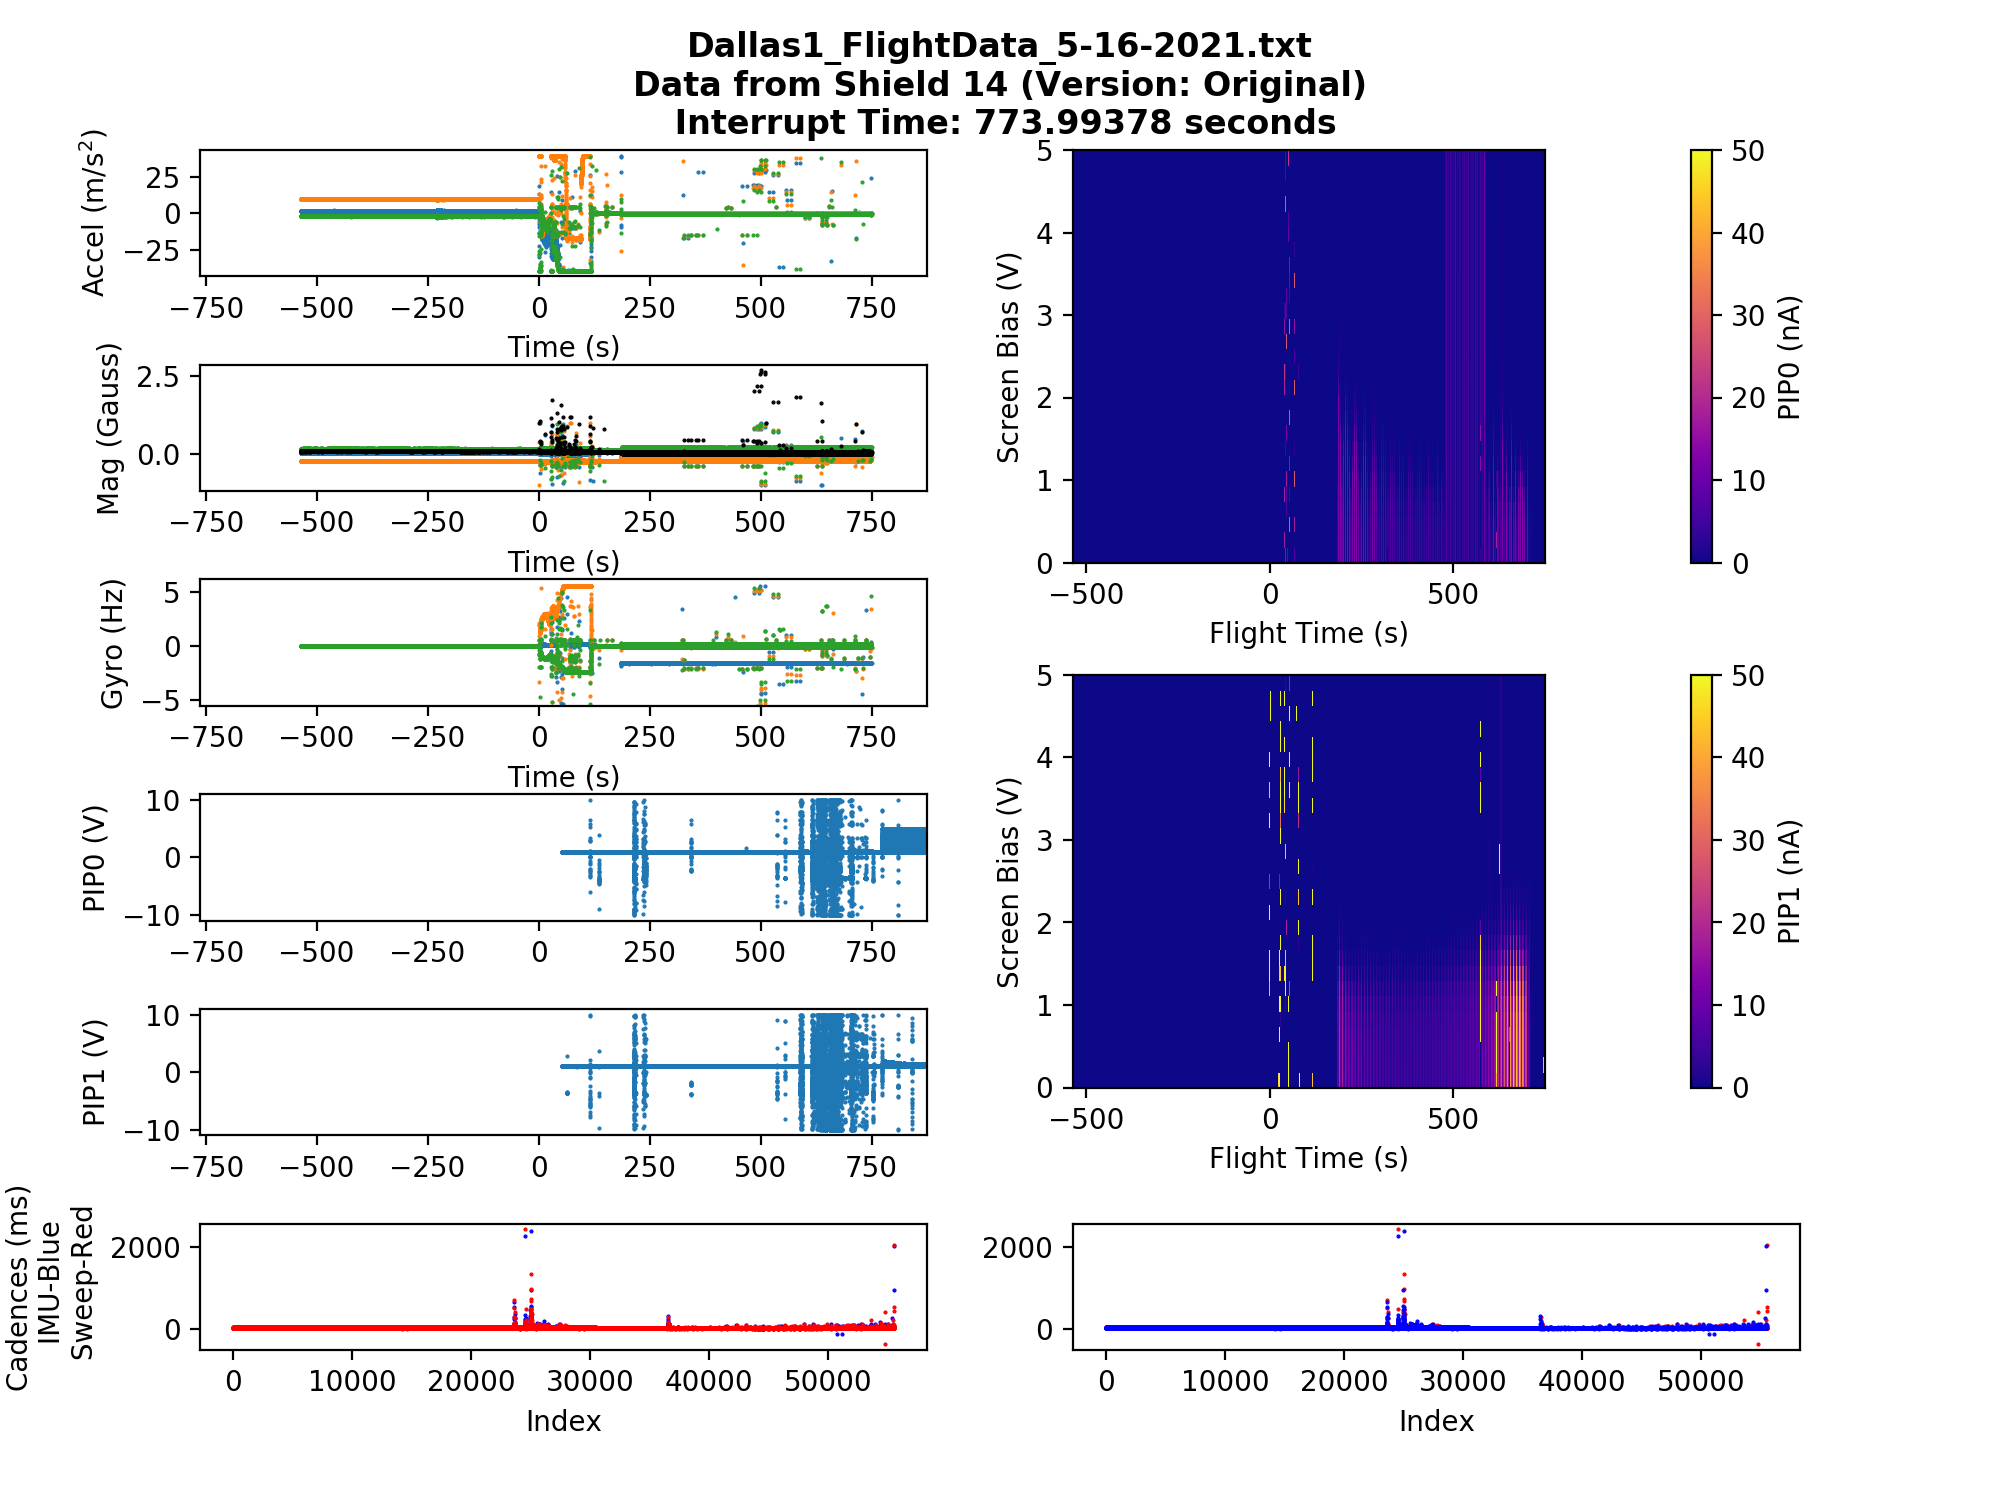

1 Done
2 Done
3 Done
4 Done
5 Done
6 Done
7 Done
8 Done
9 Done


In [8]:
matplotlib.use('nbagg')
import matplotlib.cm as cm
import scipy.signal as sig
from scipy.interpolate import interp1d
from scipy.io import savemat, loadmat
from __future__ import division

dots = True

gs_left = plt.GridSpec(6, 2,  hspace=0.7)

# Set up dots or not more cleanly
line_style = '-'
if dots:
    line_style = '.'

markersize = 1

fig = plt.figure(figsize=(10, 7.5))

# Accel
axis1 = fig.add_subplot(gs_left[0,0])
plt.plot(imuPlot, axPlot, line_style, markersize=markersize, label='ax') 
plt.plot(imuPlot, ayPlot, line_style, markersize=markersize, label='ay')  
plt.plot(imuPlot, azPlot, line_style, markersize=markersize, label='az') 
plt.ylabel("Accel (m/s$^2$)")
#plt.ylim([-2, 2])
#plt.xlim([75, 100])
if figsuffix is not None: 
    if np.any('accel'==np.array(yLnZooms.keys())): plt.ylim(yLnZooms['accel'])
if figsuffix=="Zoom2": plt.xlim(xLnlims)
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("1 Done")

# Mag
fig.add_subplot(gs_left[1,0], sharex=axis1)
plt.plot(imuPlot, mxPlot, line_style, markersize=markersize, label='mx') 
plt.plot(imuPlot, myPlot, line_style, markersize=markersize, label='my')  
plt.plot(imuPlot, mzPlot, line_style, markersize=markersize, label='mz') 
plt.plot(imuPlot, magfullPlot, line_style, markersize=markersize, color='black', label='magfull')
#plt.ylim([-0.2, 0.25])
plt.ylabel("Mag (Gauss)")
if figsuffix is not None: 
    if np.any('mag'==np.array(yLnZooms.keys())): plt.ylim(yLnZooms['mag'])
if figsuffix=="Zoom2": plt.xlim(xLnlims)
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("2 Done")

# Gyro
fig.add_subplot(gs_left[2,0], sharex=axis1)
plt.plot(imuPlot, gxPlot, line_style, markersize=markersize, label='gx') 
plt.plot(imuPlot, gyPlot, line_style, markersize=markersize, label='gy')  
plt.plot(imuPlot, gzPlot, line_style, markersize=markersize, label='gz') 
plt.ylabel("Gyro (Hz)")
#plt.ylim([-0.5, 0.5])  
#plt.xlim([75, 100])
if figsuffix is not None: 
    if np.any('gyro'==np.array(yLnZooms.keys())): plt.ylim(yLnZooms['gyro'])
if figsuffix=="Zoom2": plt.xlim(xLnlims)
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("3 Done")

# First PIP (line)
fig.add_subplot(gs_left[3,0], sharex=axis1)
plt.plot(sweepTimeLPlot, pip0LPlot, line_style, markersize=markersize)
plt.ylabel("PIP0 (V)")
#plt.ylim([1.01, 1.03])
#plt.ylim([1.0075, 1.0125])
if figsuffix is not None: 
    if np.any('pip0'==np.array(yLnZooms.keys())): plt.ylim(yLnZooms['pip0'])
    if figsuffix=='Zoom': plt.ylim(ylims)
plt.xlim(xlims)
if figsuffix=="Zoom2": plt.xlim(xLnlims)
print("4 Done")

# Second PIP (line)
fig.add_subplot(gs_left[4,0], sharex=axis1)
plt.plot(sweepTimeLPlot, pip1LPlot, line_style, markersize=markersize)
#plt.ylim([1.027, 1.033])
#plt.ylim([1.011, 1.013])
if figsuffix is not None: 
    if np.any('pip1'==np.array(yLnZooms.keys())): plt.ylim(yLnZooms['pip1'])
    if figsuffix=='Zoom': plt.ylim(ylims2)
plt.xlim(xlims2)
if figsuffix=="Zoom2": plt.xlim(xLnlims)
plt.ylabel("PIP1 (V)")
print("5 Done")

# Make any last changes to axis1's x-axis limits
if figsuffix is not None and np.any('axis1'==np.array(xLnZooms.keys())): axis1.set_xlim(xLnZooms['axis1'])

# Cadence (sweep on top)
axis2 = fig.add_subplot(gs_left[5,0])
plt.plot(np.diff(imuPlot*1E3), line_style, color='blue', markersize=markersize)
plt.plot(np.diff(sweepPlot)*1E3, line_style, color='red', markersize=markersize)
if figsuffix is not None: 
    if figsuffix == "Zoom": 
        plt.xlim([np.round(plt.axis()[1]/2-xCzoom, decimals=-3), np.round(plt.axis()[1]/2, decimals=-3)+xCzoom])
        axis2.set_xticks(axis2.get_xticks()[::2])
        plt.ylim(ylimsC)
    if np.any('cad'==np.array(yLnZooms.keys())): plt.ylim(yLnZooms['cad'])
#plt.ylim([22,25])
#plt.xlim([200,400])
if figsuffix=="Zoom2": plt.xlim(xLnlims)
plt.ylabel("Cadences (ms)\n IMU-Blue\n Sweep-Red")
plt.xlabel("Index")
print ("6 Done")

# Cadence (imu on top)
fig.add_subplot(gs_left[5,1], sharex=axis2, sharey=axis2)
plt.plot(np.diff(sweepPlot)*1E3, line_style, color='red', markersize=markersize)
plt.plot(np.diff(imuPlot*1E3), line_style, color='blue', markersize=markersize)
#plt.ylim([22,25])
if figsuffix is not None: 
    if figsuffix == "Zoom": 
        plt.xlim([np.round(plt.axis()[1]/2-xCzoom, decimals=-3), np.round(plt.axis()[1]/2, decimals=-3)+xCzoom])
        axis2.set_xticks(axis2.get_xticks()[::2])
        plt.ylim(ylimsC)
    if np.any('cad'==np.array(yLnZooms.keys())): plt.ylim(yLnZooms['cad'])
#plt.xlim([200,400])
if figsuffix=="Zoom2": plt.xlim(xLnlims)
plt.xlabel("Index")
print ("7 Done")

# Make any last changes to axis2's x-axis limits
if figsuffix is not None: #and not np.all('axis1'==np.array(xLnZooms.keys())):
    # Zoom into the center of the x-axis
    if np.any('xCzoom'==np.array(xLnZooms.keys())):
        axis2.set_xlim([np.round(plt.axis()[1]/2-xLnZooms['xCzoom'], decimals=-3), np.round(plt.axis()[1]/2, decimals=-3)+xLnZooms['xCzoom']])
        axis2.set_xticks(axis2.get_xticks()[::2])
    # Zoom into the specified x-axis limits
    elif np.any('axis2'==np.array(xLnZooms.keys())):
        axis2.set_xlim(xLnZooms['axis2'])
    
# **Plot sweep time vs sweep data (Color plots)**

# commands to reorient pip array to match with other axes
pip0_rot = np.rot90(pip0Plot, k=1, axes=(0, 1))
pip1_rot = np.rot90(pip1Plot, k=1, axes=(0, 1))

sweep_voltage = np.linspace(0,5,28)

line_style = '-'

ax1 = plt.subplot2grid((5,2),(0,1),rowspan = 2)
plt.pcolormesh(sweepPlot, sweep_voltage, pip0_rot, cmap='plasma', **cplt_kwargs['pip0'])
plt.xlim(xlims)
ax1.set_xlabel("Flight Time (s)")
ax1.set_ylabel("Screen Bias (V)")
cb = plt.colorbar(pad = 0.2)
cb.set_label("PIP0 (nA)")
print ("8 Done")

ax1 = plt.subplot2grid((5,2),(2,1),rowspan = 2, sharex=ax1)
plt.pcolormesh(sweepPlot, sweep_voltage, pip1_rot, cmap='plasma', **cplt_kwargs['pip1'])
plt.xlim(xlims2)
ax1.set_xlabel("Flight Time (s)")
ax1.set_ylabel("Screen Bias (V)")
cb = plt.colorbar(pad = 0.2)
cb.set_label("PIP1 (nA)")
print ("9 Done")
        
# Adjust figure
fig.subplots_adjust(right=.90)
fig.subplots_adjust(left=0.10)
fig.subplots_adjust(top=0.90)
fig.subplots_adjust(bottom=0.10)
fig.subplots_adjust(hspace=0.75)

# if interruptValue and len(interruptArray) > 100:
#     interruptNum = str(interruptArray[100]) + " seconds"

# elif len(interruptArray) > 100:
if len(interruptArray) > 100:
    numRec=0
    for event in np.unique(np.array(interruptArray)): 
#         print "Number of recordings for %ss:" % (event), len(np.where(np.array(interruptArray) == event)[0]) 
        if len(np.where(np.array(interruptArray) == event)[0]) > numRec:
            numRec = len(np.where(np.array(interruptArray) == event)[0])
            if numRec>100: interruptNum = str(event-8.00622) + " seconds"
            else: interruptNum = "None"
else:
    interruptNum = "None"
    
plt.suptitle(file_name+"\n"+"Data from Shield %s (Version: %s)\n Interrupt Time: %s" 
             %(shieldID, version, interruptNum), fontweight='bold')
    
plt.show()


In [15]:
# yLnZooms['accel'] = [-4.5, 10.75]
# yLnZooms['mag'] = [-0.125, 0.0525]
# yLnZooms['gyro'] = [-0.0625, 0.025]
# yLnZooms['pip0']=[1.0025, 1.0125]
# yLnZooms['pip1']=[0.9975, 1.0075]
# figsuffix = "Zoom_Ejection" # figsuffix = 'ZoomB'
# figsuffix = "ZoomC2b"
# figsuffix = "ZoomB2_pickled"
if figsuffix is None: fig.savefig(path+"Fig_%s_%sPlot.png" % (file_name.partition(".")[0], version))
else: fig.savefig(path+"Fig_%s_%sPlot%s.png" % (file_name.partition(".")[0], version, figsuffix))
# fig.axes[3].properties()['ylim']

In [223]:
arr = [axPlot, ayPlot, azPlot]; narr = ['x', 'y', 'z']
# arr = [mxPlot, myPlot, mzPlot, magfullPlot]; narr = ['x', 'y', 'z', 'full']
# arr = [gxPlot, gyPlot, gzPlot]; narr = ['x', 'y', 'z']
# arr = [pip0LPlot, pip1LPlot]; narr = ['pip0', 'pip1']
for val, name in zip(arr, narr): 
    print name.upper(), 'Mean:', np.mean(np.round(val, decimals=3))
    bnds= [int(len(val)/2-25), int(len(val)/2+25)]
    print np.round(val, decimals=3)[bnds[0]: bnds[1]].transpose()
#     print 'Slice Mean:', np.mean(np.round(val[bnds[0]-100, bnds[1]+100], decimals=3))
# int(len(val)/2)
# len(val)

X Mean: -1.4321091584203032
[[0.19  0.237 0.221 0.233 0.165 0.159 0.156 0.16  0.157 0.145 0.173 0.234
  0.211 0.164 0.164 0.171 0.173 0.16  0.165 0.146 0.266 0.231 0.22  0.209
  0.177 0.171 0.161 0.173 0.164 0.167 0.166 0.151 0.196 0.215 0.244 0.246
  0.227 0.246 0.243 0.226 0.223 0.233 0.218 0.228 0.233 0.232 0.281 0.23
  0.136 0.269]]
Y Mean: 4.455706375385281
[[ 0.026 -0.016 -0.002  0.006  0.008  0.036  0.044  0.063  0.029  0.036
  -0.032 -0.002 -0.013  0.063  0.039  0.007  0.049  0.045  0.043  0.042
   0.045  0.004  0.014  0.033  0.08   0.043  0.054  0.056  0.047  0.039
   0.035  0.038 -0.045 -0.032 -0.042  0.024 -0.024  0.019  0.037  0.013
   0.02   0.012  0.001  0.023  0.008  0.011  0.01  -0.043 -0.161 -0.037]]
Z Mean: -3.2647035454856796
[[ 0.165  0.349  0.187  0.13   0.251  0.172  0.301  0.264  0.254  0.24
   0.098  0.106  0.005  0.276  0.226  0.255  0.258  0.246  0.266  0.26
   0.189  0.276  0.176  0.252  0.298  0.19   0.254  0.274  0.268  0.245
   0.252  0.249  0.15  -0.114  

In [39]:
## pip0_lims, pip1_lims = [0.9991608958869053, 1.0147642264226409], [0.999244027307415, 1.0108743441241954]
# pip0_lims, pip1_lims = [1.0038103223832442, 1.0466790723832442], [1.0163988013993843, 1.0368067079966066]
ax_tmp = fig.axes[0] # ln = ax_tmp.lines[0:3]; # ln.properties()
print ax_tmp.properties()['ylim']

(-43.11994018554688, 43.11874389648438)


In [32]:
# # print np.unique(np.diff(sweepTimeLPlot[np.where(np.logical_and(0<=np.diff(sweepTimeLPlot), sweepTimeLPlot[1:]>sweepTimeLPlot[0]))[0]+1]))
# print pip0LPlot
# print sweepTimeLPlot
# print sweepPlot[0] == sweepTimeLPlot[0]
# print np.diff(sweepTimeLPlot)[0]==0.0007142857143662695
# print np.where(np.diff(sweepTimeLPlot)<0)[0]
# print np.where(sweepTimeLPlot<sweepTimeLPlot[0])[0]
# print sweepTimeLPlot[227051], sweepTimeLPlot[227052]
# # print sweepTimeLPlot[np.where(np.logical_and(0<=np.diff(sweepTimeLPlot), sweepTimeLPlot[1:]>sweepTimeLPlot[0]))[0]+1]

In [19]:
color_check=['#1f77b4', '#ff7f0e', '#2ca02c']
for ax_tmp in  fig.axes:
    ln_lst = ax_tmp.lines[0:3]
    ln.properties()['color']

NameError: name 'ln' is not defined

In [28]:
"""%%%% Event Interrupt Details %%%%"""
#set(interruptArray)
print "File name %s" % dataFile
print"Num interrupt messages for payload %s: %s" %(payloadID[0], len(interrupt))
print "Num unique interrupt times: ", len(np.unique(np.array(interruptTime)/10.**6))
print '***************************************'
numRec = 0 
evtTime = None
if not len(interrupt)==0:
    prev=np.unique(np.array(interruptTime)/10.**6)[0]
    for event in np.unique(np.array(interruptTime)/10.**6): 
        if int(np.floor(event-prev)) >= 30: print "-----------------------------------------"
        print "Number of recordings for %ss:" % (event), len(np.where(np.array(interruptTime)/10.**6 == event)[0]) 
        prev=event
        if len(np.where(np.array(interruptTime)/10.**6 == event)[0]) > numRec:
            numRec = len(np.where(np.array(interruptTime)/10.**6 == event)[0])
            evtTime = event
else: 
    print "No Event Interrupts Recieved"
print '\n***************************************'
print 'Offset from IMU/Sweep Times Used = %ss' % (8.00622)
print 'Reported Interrupt Time  = %ss' % (evtTime)
print 'Corrected Interrupt Time = %ss' % (np.round(evtTime-8.00622, decimals=6))

File name ./wallops_intDel/Dallas_Vibration_20210329/Dallas1_Y-Axis_RandomVibe_3-29-2021.txt
Num interrupt messages for payload 14: 12
Num unique interrupt times:  6
***************************************
Number of recordings for 502.464728s: 2
Number of recordings for 502.530244s: 2
Number of recordings for 502.92345s: 2
-----------------------------------------
Number of recordings for 3792.494606s: 2
Number of recordings for 3809.27131s: 2
-----------------------------------------
Number of recordings for 3842.825998s: 2

***************************************
Offset from IMU/Sweep Times Used = 8.00622s
Reported Interrupt Time  = 502.464728s
Corrected Interrupt Time = 494.458508s


In [12]:
print 'Final Time in imuPlot:        %ss' % (imuPlot[-1])
print 'Final Time in sweepTimeLPlot: %ss' % (sweepTimeLPlot[-1])
print 'Final Time in sweepPlot:      %ss' % (sweepPlot[-1])

Final Time in imuPlot:        1766.488808s
Final Time in sweepTimeLPlot: 1766.5056057142856s
Final Time in sweepPlot:      1766.48632s


In [38]:
from prettytable import PrettyTable
## PIP Voltage and Noise Analysis ##
print "%%%%%%%%%%%%%%%%%%%%%% Shield "+str(shieldID)+" PIP Voltage Levels %%%%%%%%%%%%%%%%%%%%%" 
# print "------------------------------------------------------------------------------------------------"
print "(%s)" % (file_name)
print "[Noise (in a PIP Measurement) = PIP Measured Voltage - PIP Mean Voltage]"
print "[Note: Nrel = PIP Measured Voltage - Max{ABS{Mean{V>=0}-Mean Voltage, Mean{V<0}-Mean Voltage}}"
t = PrettyTable(); t.right_padding_width=0; t.left_padding_width=0
t.field_names = ['Source', '|', 'Mean{Voltage}', 'Mean{V>=0}', 'Mean{V<0}', '', 'Mean{Noise}', 'Mean{|Noise|}', 'Mean{|N_rel|}']
sp_arr = [11, 1, 15, 12, 12, 0, 14, 15, 15]
# t.field_names = ['Source', '|', 'Mean{Voltage}', '', 'Mean{Noise}', 'Mean{|Noise|}']
# sp_arr = [11, 1, 15, 0, 14, 15]
charArr=['-']*len(t.field_names); charArr[t.field_names.index(u'|')] = '|'
for pipV_arr, name in zip([pip0L, pip0RptL, sp_arr, pip1L, pip1RptL], ['PIP 1', 'PIP 1 Rpt', 'split', 'PIP 2', 'PIP 2 Rpt']): 
    if name is not 'split':
        row_arr = [name, '|']
        row_arr.append('~ %s V' %(np.format_float_positional(np.nanmean(pipV_arr), precision=3)))
        row_arr.append('~ %s V' %(np.format_float_positional(np.nanmean(pipV_arr[np.where(0<=pipV_arr)[0]]), precision=3)))
        row_arr.append('~ %s V' %(np.format_float_positional(np.nanmean(pipV_arr[np.where(pipV_arr<0)[0]]), precision=3)))
        Vavg_arr = np.array([np.nanmean(pipV_arr[np.where(0<=pipV_arr)[0]]), np.nanmean(pipV_arr[np.where(pipV_arr<0)[0]])])
        row_arr.append('')
        noise_arr = pipV_arr-np.nanmean(pipV_arr)
        nrel_arr = pipV_arr-Vavg_arr[np.where(np.abs(Vavg_arr - np.nanmean(pipV_arr))==np.nanmin(np.abs(Vavg_arr - np.nanmean(pipV_arr))))[0]]
        row_arr.append('~ %s V' %(np.format_float_scientific(np.nanmean(noise_arr), precision=1)))
        row_arr.append('~ %s mV' % (np.round(np.nanmean(np.abs(noise_arr))*1e3, decimals=1)))
        row_arr.append('~ %s mV' % (np.round(np.nanmean(np.abs(nrel_arr))*1e3, decimals=1)))
## Create section split between pip1&pip2 data
    else: row_arr=[char*ln for char, ln in zip(charArr, pipV_arr)] #row_arr=['-'*ln for ln in pipV_arr]
    t.add_row(row_arr); del row_arr
t.align = "c"
print t
del t  

%%%%%%%%%%%%%%%%%%%%%% Shield 16 PIP Voltage Levels %%%%%%%%%%%%%%%%%%%%%
(Dallas4_R4_Dallas4Deployment_3-31-2021.txt)
[Noise (in a PIP Measurement) = PIP Measured Voltage - PIP Mean Voltage]
[Note: Nrel = PIP Measured Voltage - Max{ABS{Mean{V>=0}-Mean Voltage, Mean{V<0}-Mean Voltage}}
+-----------+-+---------------+------------+------------++--------------+---------------+---------------+
|   Source  ||| Mean{Voltage} | Mean{V>=0} | Mean{V<0}  || Mean{Noise}  | Mean{|Noise|} | Mean{|N_rel|} |
+-----------+-+---------------+------------+------------++--------------+---------------+---------------+
|   PIP 1   |||   ~ 1.024 V   | ~ 1.026 V  | ~ -4.642 V || ~ -3.1e-17 V |    ~ 4.2 mV   |    ~ 5.2 mV   |
| PIP 1 Rpt |||   ~ 1.025 V   | ~ 1.025 V  | ~ -4.309 V || ~ 6.2e-17 V  |    ~ 3.1 mV   |    ~ 3.6 mV   |
|-----------|||---------------|------------|------------||--------------|---------------|---------------|
|   PIP 2   |||   ~ 1.036 V   | ~ 1.037 V  | ~ -4.969 V || ~ -1.0e-16 V |   ~

In [12]:
#Save Normal Figure 
#fig.savefig(path+"Fig_%s_%sPlot.png" % (file_name.partition(".")[0], version))

In [35]:
#Save Zoomed Figure 
#fig.savefig(path+"Fig_%s_%sPlotZoom.png" % (file_name.partition(".")[0], version))

In [11]:
# fig.savefig(path+"%s.png" % (file_name.partition(".")[0]))